In [83]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp, ttest_rel, sem, t, zscore

In [84]:
def align_x_position(x_list):
    if not x_list:  # Handle empty lists if needed
        return x_list
    shift_amount = x_list[0] - 960  # Calculate shift
    return [x - shift_amount for x in x_list] 

def flip_y_pos(y_list):
    return [-y for y in y_list] 

# auf 0,0 normalisieren jeden trial
def normalize_positions(row): 
    x_positions = row["xpos"]
    y_positions = row["ypos"]
    
    x_start, y_start = x_positions[0], y_positions[0]

    row["xpos"] = [x - x_start for x in x_positions]
    row["ypos"] = [y - y_start for y in y_positions]
    
    return row

# Interpolation auf 100 Zeiteinheiten
def interpolate_positions(row):
    original_length = len(row["xpos"])
    original_time = np.linspace(0, 1, original_length)  # Ursprünglicher Zeitvektor
    new_time = np.linspace(0, 1, 100)  # Ziel-Zeitvektor mit 100 Zeiteinheiten
    
    # Interpolation der x- und y-Positionen
    row["xpos"] = np.interp(new_time, original_time, row["xpos"])
    row["ypos"] = np.interp(new_time, original_time, row["ypos"])
    return row

def can_convert_to_int(lst):
    """Checks if every value in a list can be converted to an integer."""
    if not isinstance(lst, list):  
        return False  # Ensure input is a list
    
    try:
        return all(isinstance(int(x), int) for x in lst)  # Try converting each element
    except (ValueError, TypeError):  
        return False  # If any element fails, return False

In [85]:
directory = "data"
mouse_data_regex = r"mouse_data_(\d+)"
grouped_data = []

for filename in os.listdir(directory):
    mouse_data_match = re.search(mouse_data_regex, filename)

    if mouse_data_match:
        participant_num = int(mouse_data_match.group(1))
        file_path = os.path.join(directory, filename)

        df_mouse_data =  pd.read_csv(file_path, sep=",")
        grouped_mouse_data = df_mouse_data.groupby(["blocknumber", "trialnumber"]).agg({
            "timedifference": list,  
            "xpos": list,            
            "ypos": list             
        }).reset_index()    

        grouped_mouse_data["xpos"] = grouped_mouse_data["xpos"].apply(align_x_position)

        grouped_mouse_data["ypos"] = grouped_mouse_data["ypos"].apply(flip_y_pos)
        
        grouped_mouse_data = grouped_mouse_data.apply(normalize_positions, axis=1)

        grouped_mouse_data = grouped_mouse_data.apply(interpolate_positions, axis=1)

        grouped_mouse_data["participant_num"] = participant_num

        grouped_data.append(grouped_mouse_data)
        #print(grouped_mouse_data["participant_num"])
        
        #print(len(grouped_mouse_data["xpos"]))
        #print(df_mouse_data.groupby("blocknumber")["trialnumber"].nunique())

        #print(df_mouse_data["blocknumber"].nunique(), df_mouse_data["trialnumber"].nunique())
        #print(df_mouse_data.groupby(["blocknumber", "trialnumber"]).size().unstack())

grouped_data[0]["ypos"]


0       [0.0, 14.86868686868687, 36.60606060606061, 55...
1       [0.0, 6.363636363636364, 15.181818181818183, 2...
2       [0.0, 10.282828282828284, 24.484848484848488, ...
3       [0.0, 0.9595959595959597, 1.9191919191919193, ...
4       [0.0, 7.757575757575758, 16.454545454545457, 2...
                              ...                        
1243    [0.0, 10.909090909090908, 25.81818181818182, 4...
1244    [0.0, 5.666666666666667, 11.484848484848486, 1...
1245    [0.0, 3.7575757575757573, 8.393939393939394, 1...
1246    [0.0, 5.6565656565656575, 11.444444444444446, ...
1247    [0.0, 5.93939393939394, 11.878787878787879, 17...
Name: ypos, Length: 1248, dtype: object

## Für manche Trials wurden keine Messwerte aufgezeichnet aus irgendeinem grund... also sind die unterschiedlich lang die grouped_mouse_data
### Wir müssen die die nicht aufgezeichnet wurden als "fail" btrachten eigentlich und rauslöschen.. (macht aber eigentlich nix) -> Sonderfall für 6 noch beachten!!!

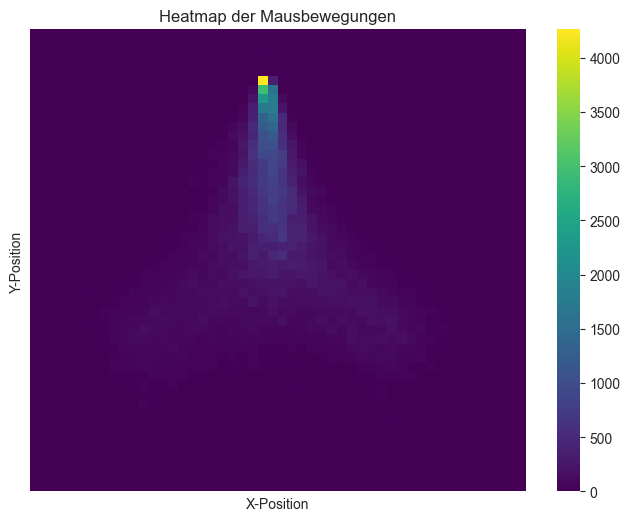

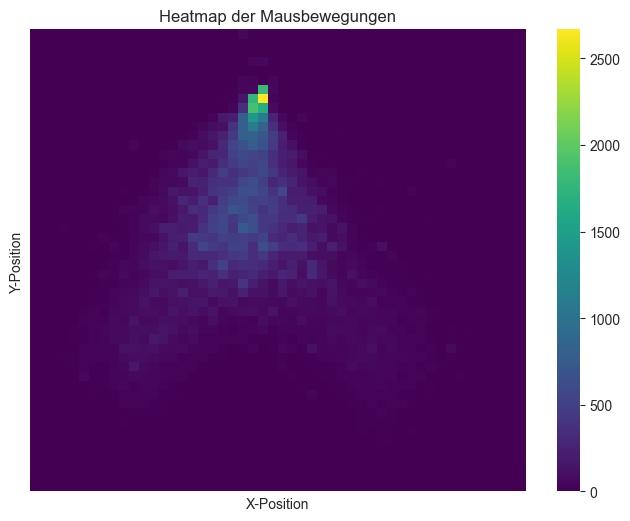

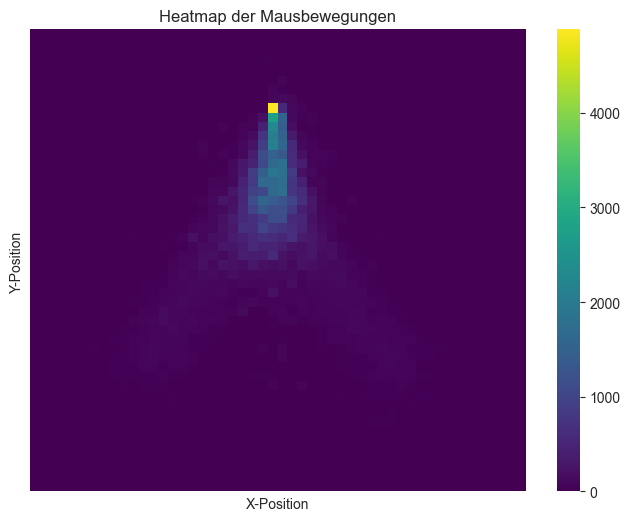

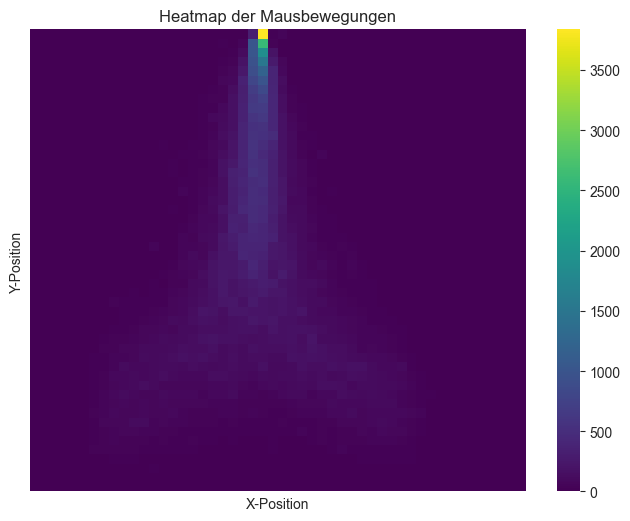

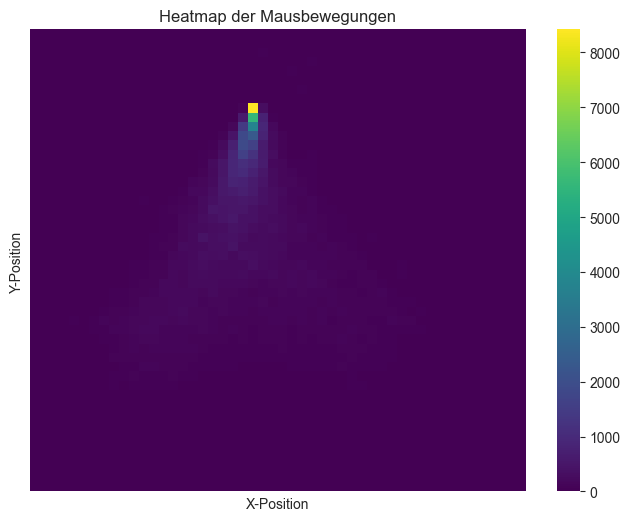

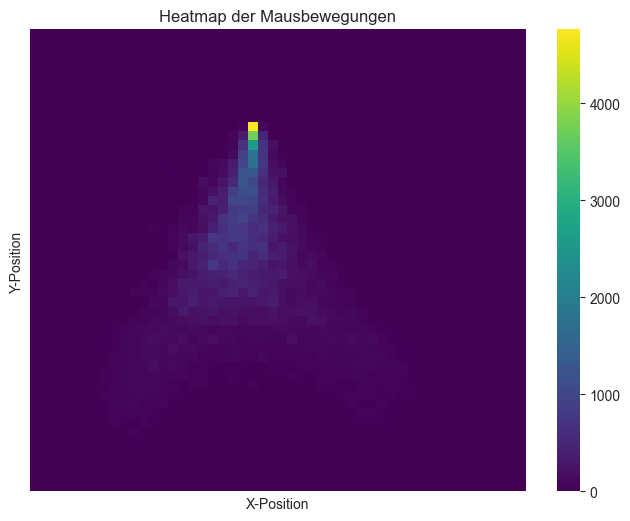

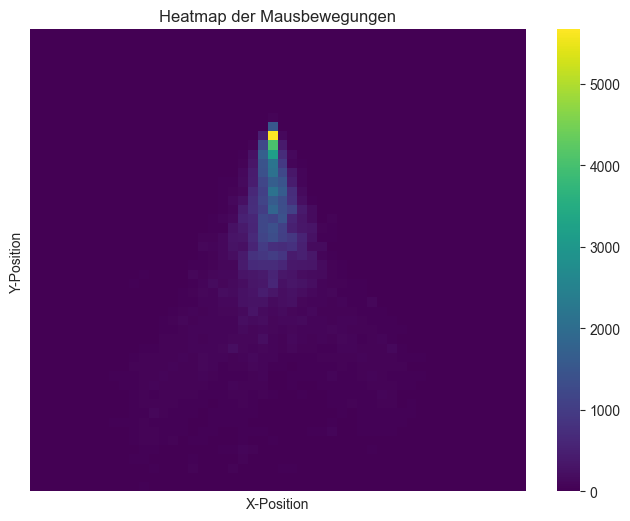

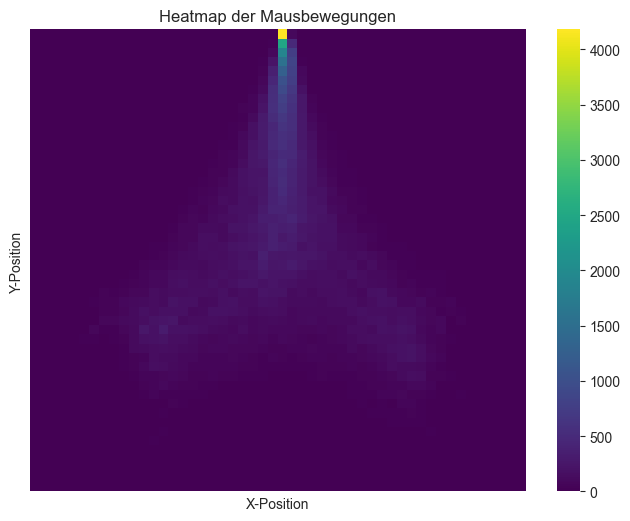

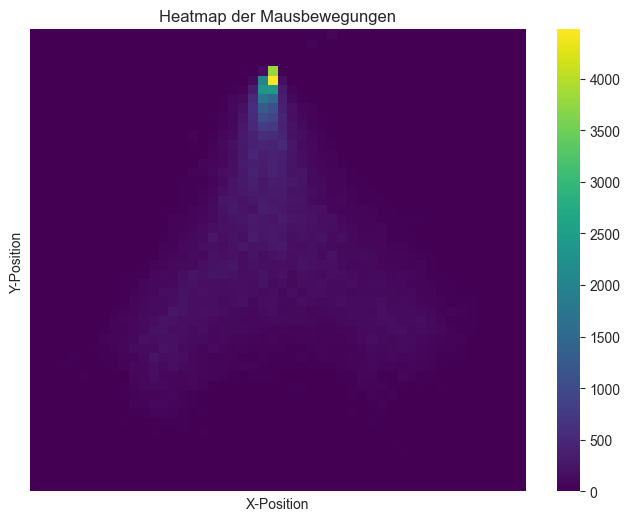

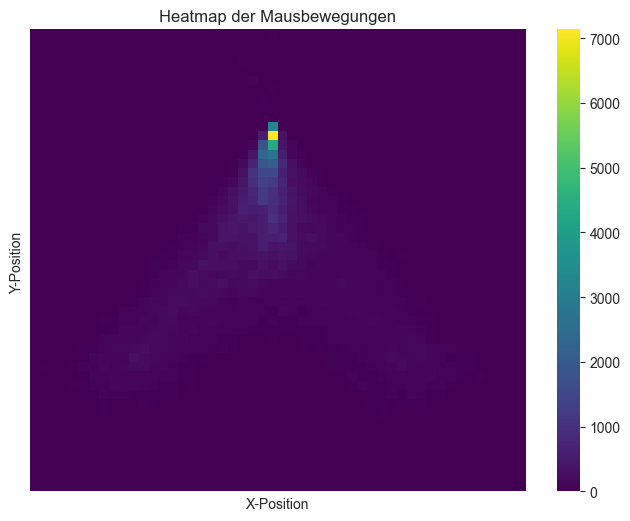

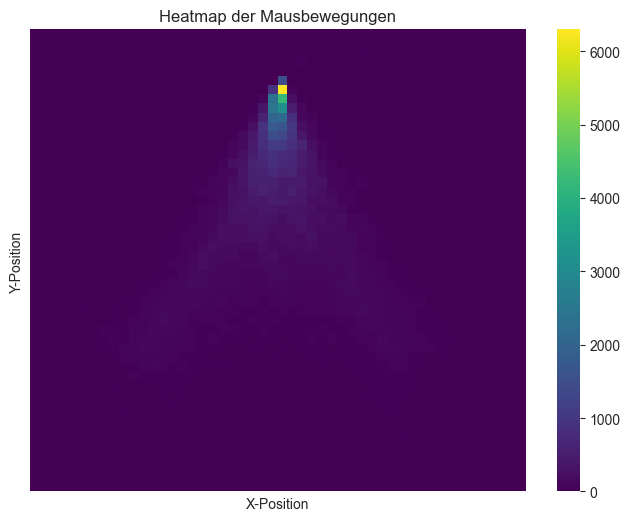

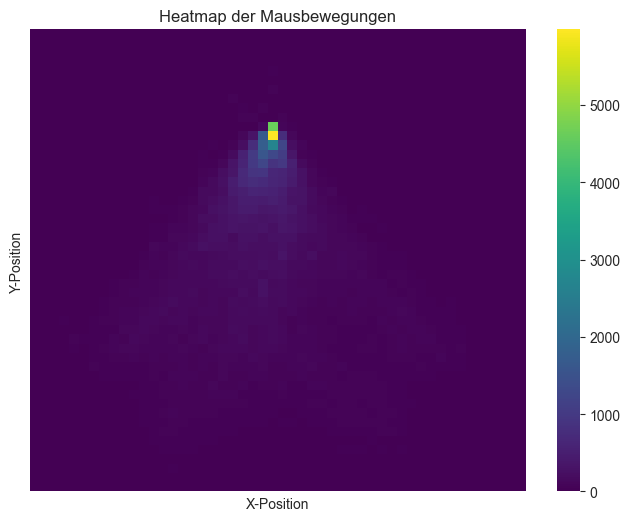

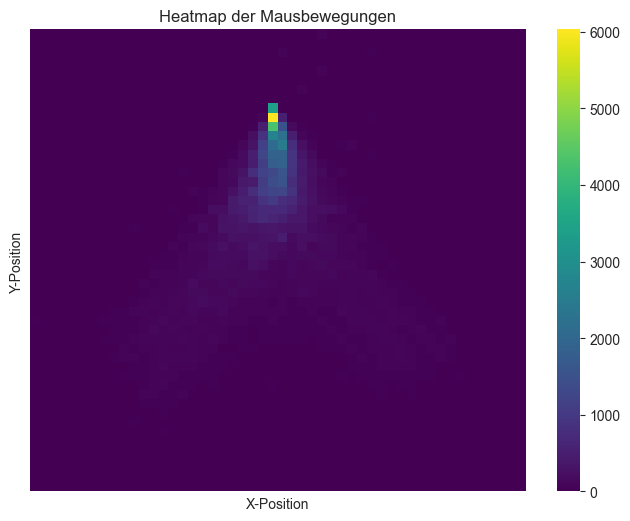

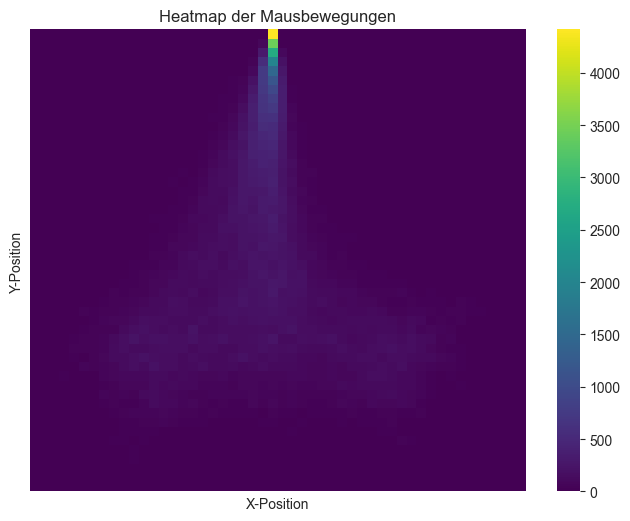

In [86]:
for grouped_mouse_data in grouped_data:
    all_xpos = [x for trial in grouped_mouse_data["xpos"] for x in trial]
    all_ypos = [y for trial in grouped_mouse_data["ypos"] for y in trial]

    # 2D-Histogramm erstellen (Heatmap-Daten)
    heatmap_data, x_edges, y_edges = np.histogram2d(
        all_xpos, all_ypos, bins=50  # 50x50 Raster
    )

    # Heatmap darstellen
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data.T,  # Transponieren, da np.histogram2d die Achsen vertauscht
        cmap="viridis",  # Farbpalette (z. B. 'viridis', 'plasma', 'coolwarm')
        xticklabels=False, yticklabels=False  # Achsenbeschriftung entfernen
    )
    plt.title("Heatmap der Mausbewegungen")
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.show()

In [87]:
condition_0_participants = [1, 6, 2, 4, 9, 11, 13] 


condition_0_data_mouse = []
condition_1_data_mouse = []

for grouped_mouse_data in grouped_data:
    if grouped_mouse_data['participant_num'].iloc[0] in condition_0_participants:
        condition_0_data_mouse.append(grouped_mouse_data)
    else:
        condition_1_data_mouse.append(grouped_mouse_data)
print(len(condition_0_data_mouse)) # sind 8 weil der 6er ja zweimal da is
print(len(condition_1_data_mouse))

7
7


In [88]:
directory = "data"

trial_data_regex = r"trial_data_(\d+)"

all_trial_data = []

for filename in os.listdir(directory):
    trial_data_match = re.search(trial_data_regex, filename)

    if trial_data_match:
        participant_num = int(trial_data_match.group(1))
        file_path = os.path.join(directory, filename)

        df_trial_data = pd.read_csv(file_path, sep=",")

        # fix congruency
        df_trial_data["currentcongruency"] = (df_trial_data["currentdirection"] == df_trial_data["currentlocation"]).astype(int)
        df_trial_data["previouscongruency"] = (df_trial_data["previousdirection"] == df_trial_data["previouslocation"]).astype(int)

        df_trial_data["participant_num"] = participant_num

        all_trial_data.append(df_trial_data)
        # print(all_trial_data)

In [89]:
condition_0_participants = [1, 6, 2, 4, 9, 11, 13] 

condition_0_data_trial = []
condition_1_data_trial = []

for df in all_trial_data:
    participant_num = df["participant_num"].iloc[0]
    
    if participant_num in condition_0_participants:
        condition_0_data_trial.append(df)
    else:
        condition_1_data_trial.append(df)

print(len(condition_0_data_trial))
print(len(condition_1_data_trial))

7
7


In [90]:
condition_0_with_latency = []
condition_0_no_latency = []

for trial_list in condition_0_data_trial:
    df = pd.DataFrame(trial_list)
    
    with_latency = df.loc[df["blocknumber"].isin([1, 2])].copy()
    no_latency = df.loc[df["blocknumber"].isin([3, 4])].copy()
    
    condition_0_with_latency.append(with_latency)
    condition_0_no_latency.append(no_latency)


In [91]:
condition_1_with_latency = []
condition_1_no_latency = []

for trial_list in condition_1_data_trial:
    df = pd.DataFrame(trial_list)
    
    with_latency = df.loc[df["blocknumber"].isin([3, 4])].copy()
    no_latency = df.loc[df["blocknumber"].isin([1, 2])].copy()
    
    condition_1_with_latency.append(with_latency)
    condition_1_no_latency.append(no_latency)

In [92]:
# Wieder zusammengefügt und nach latenz condition gesplittet!
combined_trial_data_with_latency = condition_0_with_latency + condition_1_with_latency
combined_trial_data_no_latency = condition_0_no_latency + condition_1_no_latency

In [93]:
len(combined_trial_data_with_latency[0])

642

In [94]:
condition_0_with_latency_mouse = []
condition_0_no_latency_mouse = []

for mouse_df in condition_0_data_mouse:  
    with_latency = mouse_df.loc[mouse_df["blocknumber"].isin([1, 2])].copy()
    no_latency = mouse_df.loc[mouse_df["blocknumber"].isin([3, 4])].copy()
    
    condition_0_with_latency_mouse.append(with_latency)
    condition_0_no_latency_mouse.append(no_latency)


condition_1_with_latency_mouse = []
condition_1_no_latency_mouse = []

for mouse_df in condition_1_data_mouse:  
    with_latency = mouse_df.loc[mouse_df["blocknumber"].isin([3, 4])].copy()
    no_latency = mouse_df.loc[mouse_df["blocknumber"].isin([1, 2])].copy()
    
    condition_1_with_latency_mouse.append(with_latency)
    condition_1_no_latency_mouse.append(no_latency)

combined_with_latency_mouse = condition_0_with_latency_mouse + condition_1_with_latency_mouse
combined_no_latency_mouse = condition_0_no_latency_mouse + condition_1_no_latency_mouse

In [95]:
print(len(combined_no_latency_mouse[0]))

640


In [96]:
combined_with_latency_df = pd.concat(combined_trial_data_with_latency, ignore_index=True)
combined_with_latency_mouse_df = pd.concat(combined_with_latency_mouse, ignore_index=True)

combined_with_latency_final = pd.merge(
    combined_with_latency_df,       
    combined_with_latency_mouse_df,
    on=["trialnumber", "blocknumber", "participant_num"],
    how="inner"                      
)

print(combined_with_latency_final.columns)

Index(['trialnumber', 'blocknumber', 'success', 'reactiontime',
       'currentcongruency', 'currentdirection', 'currentlocation',
       'previouscongruency', 'previousdirection', 'previouslocation',
       'participant_num', 'timedifference', 'xpos', 'ypos'],
      dtype='object')


In [97]:
print(combined_with_latency_final.iloc[0])

trialnumber                                                           4
blocknumber                                                           1
success                                                               1
reactiontime                                                        462
currentcongruency                                                     0
currentdirection                                                      1
currentlocation                                                       0
previouscongruency                                                    1
previousdirection                                                     0
previouslocation                                                      0
participant_num                                                       1
timedifference        [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...
xpos                  [0.0, -1.8585858585858588, -7.151515151515152,...
ypos                  [0.0, 14.86868686868687, 36.60606060606061

In [98]:
combined_no_latency_df = pd.concat(combined_trial_data_no_latency, ignore_index=True)
combined_no_latency_mouse_df = pd.concat(combined_no_latency_mouse, ignore_index=True)

combined_no_latency_final = pd.merge(
    combined_no_latency_df,       
    combined_no_latency_mouse_df,
    on=["trialnumber", "blocknumber", "participant_num"],
    how="inner"                      
)

print(len(combined_no_latency_final))

8962


## Preprocessing

### Fehlerhafte Trials ausschließen

In [99]:
combined_with_latency_final["remove"] = combined_with_latency_final["success"] == 0
combined_with_latency_final["remove"] = combined_with_latency_final["remove"] | combined_with_latency_final["remove"].shift(1, fill_value=0)
combined_with_latency_final_errors = combined_with_latency_final[~combined_with_latency_final["remove"]].drop(columns=["remove"])

print(f"Mit Latenz: Es wurden {len(combined_with_latency_final) -  len(combined_with_latency_final_errors)} fehlerhafte Trials von insgesamt {len(combined_with_latency_final)} entfernt")

Mit Latenz: Es wurden 668 fehlerhafte Trials von insgesamt 8923 entfernt


In [100]:
combined_no_latency_final["remove"] = combined_no_latency_final["success"] == 0
combined_no_latency_final["remove"] = combined_no_latency_final["remove"] | combined_no_latency_final["remove"].shift(1, fill_value=0)
combined_no_latency_final_errors = combined_no_latency_final[~combined_no_latency_final["remove"]].drop(columns=["remove"])


print(f"Ohne Latenz: Es wurden {len(combined_no_latency_final) -  len(combined_no_latency_final_errors)} fehlerhafte Trials von insgesamt {len(combined_no_latency_final)} entfernt")

Ohne Latenz: Es wurden 498 fehlerhafte Trials von insgesamt 8962 entfernt


### Ausschluss extremer Reaktionszeiten

In [101]:
averageReactiontimeWithLatency = combined_with_latency_final_errors["reactiontime"].mean()
averageReactiontimeNoLatency = combined_no_latency_final_errors["reactiontime"].mean()

print(f"Durchschnittszeit in Trials mit Latenz: {averageReactiontimeWithLatency}")
print(f"Durchschnittszeit in Trials ohne Latenz: {averageReactiontimeNoLatency}")

Durchschnittszeit in Trials mit Latenz: 502.1327680193822
Durchschnittszeit in Trials ohne Latenz: 443.5361531190926


In [102]:
mean_rt_with_latency = combined_with_latency_final_errors["reactiontime"].mean()
std_rt_with_latency = combined_with_latency_final_errors["reactiontime"].std()

combined_with_latency_final_errors["outlier"] = (combined_with_latency_final_errors["reactiontime"] < mean_rt_with_latency - 4 * std_rt_with_latency) | (combined_with_latency_final_errors["reactiontime"] > mean_rt_with_latency + 4 * std_rt_with_latency)

combined_with_latency_final_outliers = combined_with_latency_final_errors[~combined_with_latency_final_errors["outlier"]].drop(columns=["outlier"])

print(f"Mit Latenz: Von {len(combined_with_latency_final_errors)} wurden {len(combined_with_latency_final_errors) - len(combined_with_latency_final_outliers)} Trials aufgrund von zu hoher Standardabweichung entfernt.")

Mit Latenz: Von 8255 wurden 64 Trials aufgrund von zu hoher Standardabweichung entfernt.


In [103]:
mean_rt_no_latency = combined_no_latency_final_errors["reactiontime"].mean()
std_rt_no_latency = combined_no_latency_final_errors["reactiontime"].std()

combined_no_latency_final_errors["outlier"] = (combined_no_latency_final_errors["reactiontime"] < mean_rt_no_latency - 4 * std_rt_no_latency) | (combined_no_latency_final_errors["reactiontime"] > mean_rt_no_latency + 4 * std_rt_no_latency)

combined_no_latency_final_outliers = combined_no_latency_final_errors[~combined_no_latency_final_errors["outlier"]].drop(columns=["outlier"])

print(f"Ohne Latenz: Von {len(combined_no_latency_final_errors)} wurden {len(combined_no_latency_final_errors) - len(combined_no_latency_final_outliers)} Trials aufgrund von zu hoher Standardabweichung entfernt.")

Ohne Latenz: Von 8464 wurden 48 Trials aufgrund von zu hoher Standardabweichung entfernt.


### Spiegeln der Daten

In [104]:
def mirror_trajectories(row):
    if row["currentdirection"] == 1:
        row["xpos"] = [-x for x in row["xpos"]]
    return row

combined_no_latency_final_preprocessed = combined_no_latency_final_outliers
combined_with_latency_final_preprocessed = combined_with_latency_final_outliers

In [105]:
mean_rt_A_with_latency = combined_with_latency_final_preprocessed.groupby('participant_num')['reactiontime'].mean()
mean_rt_B_no_latency = combined_no_latency_final_preprocessed.groupby('participant_num')['reactiontime'].mean()

comparison_df = pd.DataFrame({
    'participant_num': mean_rt_A_with_latency.index,
    'rt_with_latency': mean_rt_A_with_latency.values,
    'rt_no_latency': mean_rt_B_no_latency.values
})

# Calculate difference scores
comparison_df['rt_difference'] = comparison_df['rt_with_latency'] - comparison_df['rt_no_latency']

# Run paired t-test
t_stat, p_value = ttest_rel(comparison_df['rt_with_latency'], comparison_df['rt_no_latency'])
 

In [106]:
# Print results
print("Paired Samples T-Test Results:")
print("-" * 40)
print(f"Mean RT (With Latency): {comparison_df['rt_with_latency'].mean():.2f} ms")
print(f"Mean RT (No Latency): {comparison_df['rt_no_latency'].mean():.2f} ms")
print(f"Mean difference: {comparison_df['rt_difference'].mean():.2f} ms")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")

# Effect size (Cohen's d for paired samples)
cohens_d = (comparison_df['rt_difference'].mean() / 
            comparison_df['rt_difference'].std())
print(f"Effect size (Cohen's d): {cohens_d:.4f}")

Paired Samples T-Test Results:
----------------------------------------
Mean RT (With Latency): 497.29 ms
Mean RT (No Latency): 439.55 ms
Mean difference: 57.74 ms
t-statistic: 10.3087
p-value: 0.00000013
Significant difference: Yes (α = 0.05)
Effect size (Cohen's d): 2.7551


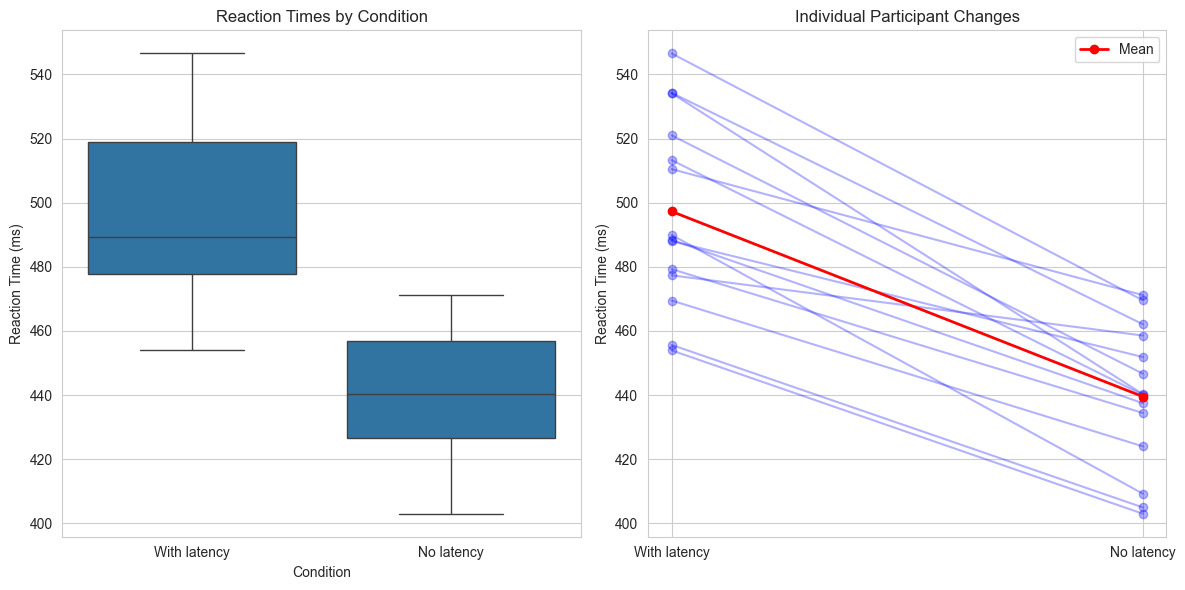

In [107]:
# Visualize the results
plt.figure(figsize=(12, 6))

# 1. Create a boxplot comparing conditions
plt.subplot(1, 2, 1)
comparison_long = pd.melt(comparison_df, 
                          id_vars=['participant_num'], 
                          value_vars=['rt_with_latency', 'rt_no_latency'],
                          var_name='condition', value_name='reaction_time')
sns.boxplot(x='condition', y='reaction_time', data=comparison_long)
plt.title('Reaction Times by Condition')
plt.xlabel('Condition')
plt.ylabel('Reaction Time (ms)')
plt.xticks([0, 1], ['With latency', 'No latency'])

# 2. Create a paired plot showing individual differences
plt.subplot(1, 2, 2)
for i, row in comparison_df.iterrows():
    plt.plot([1, 2], [row['rt_with_latency'], row['rt_no_latency']], 
             'o-', alpha=0.3, color='blue')

plt.plot([1, 2], [comparison_df['rt_with_latency'].mean(), 
                  comparison_df['rt_no_latency'].mean()], 
         'o-', linewidth=2, color='red', label='Mean')

plt.title('Individual Participant Changes')
plt.ylabel('Reaction Time (ms)')
plt.xticks([1, 2], ['With latency', 'No latency'])
plt.legend()

plt.tight_layout()
plt.show()

#### Werte-Helfer

location: 1 = rechts; 0 = links
direction: 1 = rechts; 0 = links
congruencsy: 1 = congruent; 0 = inknongruent

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### tests für kongruenz(n) und kongruenz(n-1) (für beide Konditions um Replikation zu bestätigen)

#### Kongruenz-Vergleich (Gruppe ohne Latenz)

In [108]:
#model = ols("reactiontime ~ C(currentcongruency) * C(previouscongruency)", data=df).fit()
#anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA for balanced design
#print(anova_table)

#need to aggregate because each participant has multiple trials with same conditions
aggregated_df_no_latency = combined_no_latency_final_preprocessed.groupby(['participant_num', 'currentcongruency', 'previouscongruency'])['reactiontime'].mean().reset_index()

aovrm = AnovaRM(aggregated_df_no_latency, 'reactiontime', 'participant_num', within=['currentcongruency', 'previouscongruency'])
anova_res_no_latency = aovrm.fit()

print(anova_res_no_latency.summary())

                               Anova
                                     F Value  Num DF  Den DF Pr > F
-------------------------------------------------------------------
currentcongruency                    135.0367 1.0000 13.0000 0.0000
previouscongruency                     5.1080 1.0000 13.0000 0.0416
currentcongruency:previouscongruency  82.9316 1.0000 13.0000 0.0000



In [109]:
# Extract and print p-values specifically
print("\nANOVA Results - Congruency on Reactiontime (no latency):")
print("-" * 50)
results_df_no_latency = anova_res_no_latency.anova_table
print(f"Current Congruency Effect: F({results_df_no_latency.loc['currentcongruency', 'Num DF']:.1f}, {results_df_no_latency.loc['currentcongruency', 'Den DF']:.1f}) = {results_df_no_latency.loc['currentcongruency', 'F Value']:.2f}, p = {results_df_no_latency.loc['currentcongruency', 'Pr > F']:.8f}")
print(f"Previous Congruency Effect: F({results_df_no_latency.loc['previouscongruency', 'Num DF']:.1f}, {results_df_no_latency.loc['previouscongruency', 'Den DF']:.1f}) = {results_df_no_latency.loc['previouscongruency', 'F Value']:.2f}, p = {results_df_no_latency.loc['previouscongruency', 'Pr > F']:.6f}")
print(f"Interaction Effect: F({results_df_no_latency.loc['currentcongruency:previouscongruency', 'Num DF']:.1f}, {results_df_no_latency.loc['currentcongruency:previouscongruency', 'Den DF']:.1f}) = {results_df_no_latency.loc['currentcongruency:previouscongruency', 'F Value']:.2f}, p = {results_df_no_latency.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")


ANOVA Results - Congruency on Reactiontime (no latency):
--------------------------------------------------
Current Congruency Effect: F(1.0, 13.0) = 135.04, p = 0.00000003
Previous Congruency Effect: F(1.0, 13.0) = 5.11, p = 0.041625
Interaction Effect: F(1.0, 13.0) = 82.93, p = 0.00000053


In [153]:
# Calculate and print mean values for each condition
condition_means_no_latency = aggregated_df_no_latency.groupby(['currentcongruency', 'previouscongruency'])['reactiontime'].mean().reset_index()

print("\nAnova results for congruency (current/previous) on RT (No latency):")
print("\nMean Reaction Times for Each Condition:")
print("-" * 50)
for _, row in condition_means_no_latency.iterrows():
    current = "Congruent" if row['currentcongruency'] == 1 else "Incongruent"
    previous = "Congruent" if row['previouscongruency'] == 1 else "Incongruent"
    print(f"Previous: {previous:<11} Current: {current:<11} Mean RT: {row['reactiontime']:.2f} ms")

# Calculate main effects
print("\nMain Effects:")
print("-" * 50)
current_effect = condition_means_no_latency.groupby('currentcongruency')['reactiontime'].mean()
print(f"Current Congruency Effect: Incongruent: {current_effect[0]:.2f} ms, Congruent: {current_effect[1]:.2f} ms")
print(f"Congruency Effect Size: {current_effect[0] - current_effect[1]:.2f} ms")
print(f"Statistical Significance: p = {results_df_no_latency.loc['currentcongruency', 'Pr > F']:.8f}\n")

previous_effect = condition_means_no_latency.groupby('previouscongruency')['reactiontime'].mean()
print(f"Previous Congruency Effect: Incongruent: {previous_effect[0]:.2f} ms, Congruent: {previous_effect[1]:.2f} ms")
print(f"Previous Trial Effect Size: {previous_effect[0] - previous_effect[1]:.2f} ms")
print(f"Statistical Significance: p = {results_df_no_latency.loc['previouscongruency', 'Pr > F']:.6f}\n")

# Examine the interaction (Gratton effect)
cc_effect_after_c = condition_means_no_latency[condition_means_no_latency['previouscongruency']==1]['reactiontime'].values
cc_effect_after_c = cc_effect_after_c[0] - cc_effect_after_c[1] if len(cc_effect_after_c) > 1 else "N/A"

cc_effect_after_ic = condition_means_no_latency[condition_means_no_latency['previouscongruency']==0]['reactiontime'].values
cc_effect_after_ic = cc_effect_after_ic[0] - cc_effect_after_ic[1] if len(cc_effect_after_ic) > 1 else "N/A"

print("Interaction:")
print("-" * 50)
print(f"Congruency effect after congruent trial: {cc_effect_after_c:.2f} ms")
print(f"Congruency effect after incongruent trial: {cc_effect_after_ic:.2f} ms")
print(f"Difference in congruency effects: {cc_effect_after_c - cc_effect_after_ic:.2f} ms")
print(f"Statistical Significance: p = {results_df_no_latency.loc['currentcongruency:previouscongruency', 'Pr > F']:.6f}")




Anova results for congruency (current/previous) on RT (No latency):

Mean Reaction Times for Each Condition:
--------------------------------------------------
Previous: Incongruent Current: Incongruent Mean RT: 463.46 ms
Previous: Congruent   Current: Incongruent Mean RT: 499.82 ms
Previous: Incongruent Current: Congruent   Mean RT: 411.63 ms
Previous: Congruent   Current: Congruent   Mean RT: 389.68 ms

Main Effects:
--------------------------------------------------
Current Congruency Effect: Incongruent: 481.64 ms, Congruent: 400.66 ms
Congruency Effect Size: 80.98 ms
Statistical Significance: p = 0.00000003

Previous Congruency Effect: Incongruent: 437.54 ms, Congruent: 444.75 ms
Previous Trial Effect Size: -7.21 ms
Statistical Significance: p = 0.041625

Interaction:
--------------------------------------------------
Congruency effect after congruent trial: 110.13 ms
Congruency effect after incongruent trial: 51.83 ms
Difference in congruency effects: 58.30 ms
Statistical Signif

In [111]:
def visualize_anova_results(df, key, key_label, title, showErrorBars=True):
    grouped_data = df.groupby(['previouscongruency', 'currentcongruency'])[key].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')

    # Define markers and lines for current congruency
    markers = ['o', 's']
    linestyles = ['-', '--']
    colors = ['blue', 'red']
    labels = ['Current: Congruent', 'Current: Incongruent']

    x_mapping = {1: 0, 0: 1}

    # Create the plot
    for i, current in enumerate([1, 0]):
        subset = grouped_data[grouped_data['currentcongruency'] == current]
        subset = subset.sort_values('previouscongruency', ascending=False)
        x_values = [x_mapping[prev] for prev in subset['previouscongruency']]

        plt.plot(x_values, subset[key], 
                marker=markers[i], linestyle=linestyles[i], color=colors[i], 
                linewidth=2, markersize=10, label=labels[i])

    # Customize x-axis
    plt.xticks([0, 1], ['Congruent', 'Incongruent'])
    plt.xlabel('Previous Congruency', fontsize=14)
    plt.ylabel(key_label, fontsize=14)
    plt.title(f'{title}', fontsize=16)
    plt.legend(loc='best', fontsize=12)

    # Add error bars (standard error)
    if showErrorBars:
        for i, current in enumerate([1, 0]):
            for j, previous in enumerate([1, 0]):
                subset = df[(df['currentcongruency'] == current) & (df['previouscongruency'] == previous)]
                mean = subset[key].mean()
                se = subset[key].std() / np.sqrt(len(subset))
                plt.errorbar(x_mapping[previous], mean, yerr=se, fmt='none', capsize=5, 
                            ecolor=colors[i], alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

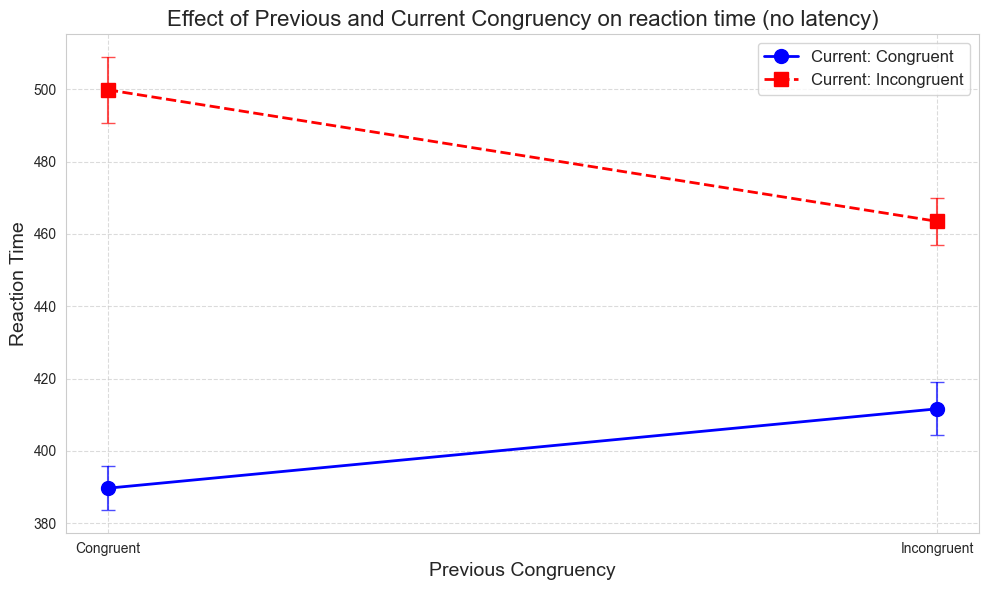

In [112]:
visualize_anova_results(aggregated_df_no_latency, "reactiontime", "Reaction Time", "Effect of Previous and Current Congruency on reaction time (no latency)")

#### Kongruenz-Vergleich (Gruppe mit Latenz)

In [113]:
#need to aggregate because each participant has multiple trials with same conditions
aggregated_df_with_latency = combined_with_latency_final_preprocessed.groupby(['participant_num', 'currentcongruency', 'previouscongruency'])['reactiontime'].mean().reset_index()

aovrm = AnovaRM(aggregated_df_with_latency, 'reactiontime', 'participant_num', within=['currentcongruency', 'previouscongruency'])
anova_res_with_latency = aovrm.fit()

print(anova_res_with_latency.summary())

                               Anova
                                     F Value  Num DF  Den DF Pr > F
-------------------------------------------------------------------
currentcongruency                     90.5169 1.0000 13.0000 0.0000
previouscongruency                     2.3494 1.0000 13.0000 0.1493
currentcongruency:previouscongruency 112.0917 1.0000 13.0000 0.0000



In [114]:
# Extract and print p-values specifically
print("\nANOVA Results - Congruency on Reactiontime (with latency):")
print("-" * 50)
results_df_with_latency = anova_res_with_latency.anova_table
print(f"Current Congruency Effect: F({results_df_with_latency.loc['currentcongruency', 'Num DF']:.1f}, {results_df_with_latency.loc['currentcongruency', 'Den DF']:.1f}) = {results_df_with_latency.loc['currentcongruency', 'F Value']:.2f}, p = {results_df_with_latency.loc['currentcongruency', 'Pr > F']:.8f}")
print(f"Previous Congruency Effect: F({results_df_with_latency.loc['previouscongruency', 'Num DF']:.1f}, {results_df_with_latency.loc['previouscongruency', 'Den DF']:.1f}) = {results_df_with_latency.loc['previouscongruency', 'F Value']:.2f}, p = {results_df_with_latency.loc['previouscongruency', 'Pr > F']:.6f}")
print(f"Interaction Effect: F({results_df_with_latency.loc['currentcongruency:previouscongruency', 'Num DF']:.1f}, {results_df_with_latency.loc['currentcongruency:previouscongruency', 'Den DF']:.1f}) = {results_df_with_latency.loc['currentcongruency:previouscongruency', 'F Value']:.2f}, p = {results_df_with_latency.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")


ANOVA Results - Congruency on Reactiontime (with latency):
--------------------------------------------------
Current Congruency Effect: F(1.0, 13.0) = 90.52, p = 0.00000032
Previous Congruency Effect: F(1.0, 13.0) = 2.35, p = 0.149303
Interaction Effect: F(1.0, 13.0) = 112.09, p = 0.00000009


In [115]:
# Calculate and print mean values for each condition
condition_means_with_latency = aggregated_df_with_latency.groupby(['currentcongruency', 'previouscongruency'])['reactiontime'].mean().reset_index()

print("\nAnova results for congruency (current/previous) on RT (With latency):")
print("\nMean Reaction Times for Each Condition:")
print("-" * 50)
for _, row in condition_means_with_latency.iterrows():
    current = "Congruent" if row['currentcongruency'] == 1 else "Incongruent"
    previous = "Congruent" if row['previouscongruency'] == 1 else "Incongruent"
    print(f"Previous: {previous:<11} Current: {current:<11} Mean RT: {row['reactiontime']:.2f} ms")

# Calculate main effects
print("\nMain Effects:")
print("-" * 50)
current_effect = condition_means_with_latency.groupby('currentcongruency')['reactiontime'].mean()
print(f"Current Congruency Effect: Incongruent: {current_effect[0]:.2f} ms, Congruent: {current_effect[1]:.2f} ms")
print(f"Congruency Effect Size: {current_effect[0] - current_effect[1]:.2f} ms")
print(f"Statistical Significance: p = {results_df_with_latency.loc['currentcongruency', 'Pr > F']:.8f}\n")

previous_effect = condition_means_with_latency.groupby('previouscongruency')['reactiontime'].mean()
print(f"Previous Congruency Effect: Incongruent: {previous_effect[0]:.2f} ms, Congruent: {previous_effect[1]:.2f} ms")
print(f"Previous Trial Effect Size: {previous_effect[0] - previous_effect[1]:.2f} ms")
print(f"Statistical Significance: p = {results_df_with_latency.loc['previouscongruency', 'Pr > F']:.8f}\n")

# Examine the interaction (Gratton effect)
cc_effect_after_c = condition_means_with_latency[condition_means_with_latency['previouscongruency']==1]['reactiontime'].values
cc_effect_after_c = cc_effect_after_c[0] - cc_effect_after_c[1] if len(cc_effect_after_c) > 1 else "N/A"

cc_effect_after_ic = condition_means_with_latency[condition_means_with_latency['previouscongruency']==0]['reactiontime'].values
cc_effect_after_ic = cc_effect_after_ic[0] - cc_effect_after_ic[1] if len(cc_effect_after_ic) > 1 else "N/A"

print("Interaction:")
print("-" * 50)
print(f"Congruency effect after congruent trial: {cc_effect_after_c:.2f} ms")
print(f"Congruency effect after incongruent trial: {cc_effect_after_ic:.2f} ms")
print(f"Difference in congruency effects: {cc_effect_after_c - cc_effect_after_ic:.2f} ms")
print(f"Statistical Significance: p = {results_df_with_latency.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")




Anova results for congruency (current/previous) on RT (With latency):

Mean Reaction Times for Each Condition:
--------------------------------------------------
Previous: Incongruent Current: Incongruent Mean RT: 526.37 ms
Previous: Congruent   Current: Incongruent Mean RT: 561.64 ms
Previous: Incongruent Current: Congruent   Mean RT: 467.56 ms
Previous: Congruent   Current: Congruent   Mean RT: 441.55 ms

Main Effects:
--------------------------------------------------
Current Congruency Effect: Incongruent: 544.00 ms, Congruent: 454.56 ms
Congruency Effect Size: 89.45 ms
Statistical Significance: p = 0.00000032

Previous Congruency Effect: Incongruent: 496.97 ms, Congruent: 501.59 ms
Previous Trial Effect Size: -4.63 ms
Statistical Significance: p = 0.14930310

Interaction:
--------------------------------------------------
Congruency effect after congruent trial: 120.09 ms
Congruency effect after incongruent trial: 58.81 ms
Difference in congruency effects: 61.27 ms
Statistical Si

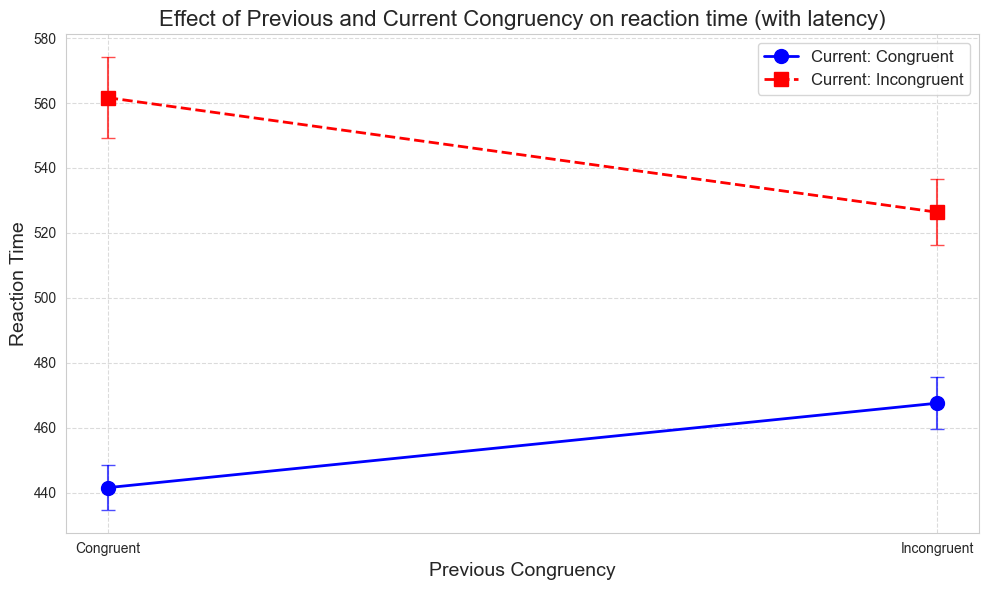

In [116]:
visualize_anova_results(aggregated_df_with_latency, "reactiontime", "Reaction Time", "Effect of Previous and Current Congruency on reaction time (with latency)")

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Krümmungsgrad-Analyse

In [117]:
# für curvature
def calculate_curvature_horizontal(xpos, ypos):
    start = np.array([xpos[0], ypos[0]])
    end = np.array([xpos[-1], ypos[-1]])
    
    # geraden
    straight_line_x = np.linspace(start[0], end[0], len(xpos))  # Normierte x werte
    straight_line_y = np.linspace(start[1], end[1], len(ypos))  # Normierte y werte. braucht man hier aber ned
    
    curvature = 0
    for x, x_line in zip(xpos, straight_line_x):
        distance = abs(x - x_line)
        curvature += distance
    
    return curvature

# Berechnung der Trajektorienlänge
def calculate_trajectory_length(xpos, ypos):
    return sum(np.sqrt((xpos[i+1] - xpos[i])**2 + (ypos[i+1] - ypos[i])**2) for i in range(len(xpos)-1))


def visualize_trajectories(df):
    plt.figure(figsize=(10, 8))

    for index, row in df.iterrows():
        xpos = row['xpos']
        ypos = row['ypos']
        
        start = [xpos[0], ypos[0]]
        end = [xpos[-1], ypos[-1]]
        
        straight_line_x = np.linspace(start[0], end[0], len(xpos))
        straight_line_y = np.linspace(start[1], end[1], len(ypos))
        
        plt.plot(straight_line_x, straight_line_y, linestyle='--', alpha=0.5, label=f'Trial {index+1}' if index < 5 else "")

    plt.title("Geradenlinien der Trajektorien")
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
    plt.grid(alpha=0.3)
    plt.show()



#### Ohne Latenz

In [118]:
combined_no_latency_final_preprocessed['curvature'] = combined_no_latency_final_preprocessed.apply(lambda row: calculate_curvature_horizontal(row['xpos'], row['ypos']), axis=1)


combined_no_latency_final_preprocessed['trajectory_length'] = combined_no_latency_final_preprocessed.apply(lambda row: calculate_trajectory_length(row['xpos'], row['ypos']), axis=1)
combined_no_latency_final_preprocessed['normalized_curvature'] = combined_no_latency_final_preprocessed['curvature'] / combined_no_latency_final_preprocessed['trajectory_length']

min_curvature = combined_no_latency_final_preprocessed['normalized_curvature'].min()
max_curvature = combined_no_latency_final_preprocessed['normalized_curvature'].max()

combined_no_latency_final_preprocessed['normalized_curvature_minmax'] = (combined_no_latency_final_preprocessed['normalized_curvature'] - min_curvature) / (max_curvature - min_curvature)

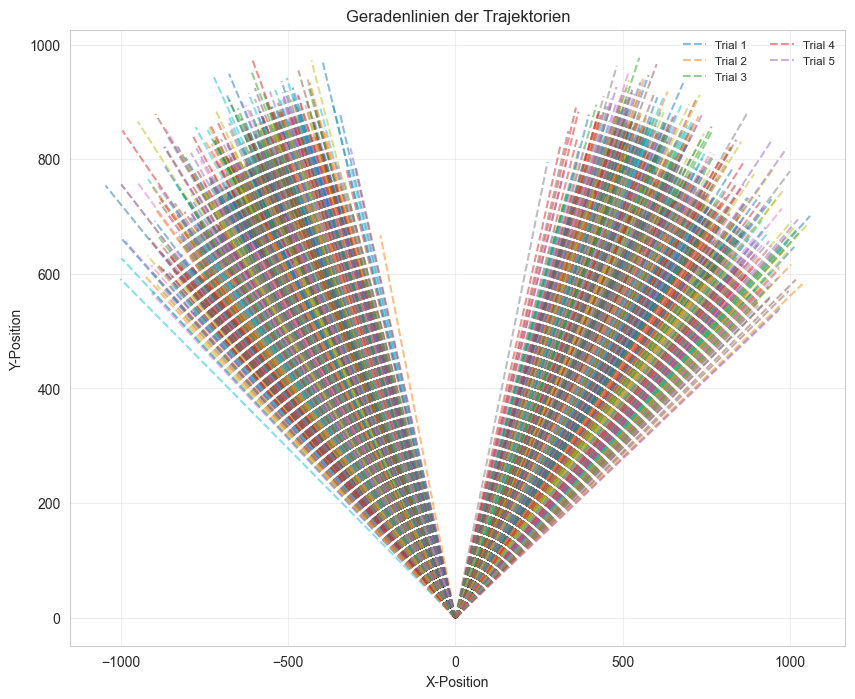

In [119]:
visualize_trajectories(combined_no_latency_final_preprocessed)

In [120]:
combined_with_latency_final_preprocessed['curvature'] = combined_with_latency_final_preprocessed.apply(lambda row: calculate_curvature_horizontal(row['xpos'], row['ypos']), axis=1)


combined_with_latency_final_preprocessed['trajectory_length'] = combined_with_latency_final_preprocessed.apply(lambda row: calculate_trajectory_length(row['xpos'], row['ypos']), axis=1)
combined_with_latency_final_preprocessed['normalized_curvature'] = combined_with_latency_final_preprocessed['curvature'] / combined_with_latency_final_preprocessed['trajectory_length']

min_curvature = combined_with_latency_final_preprocessed['normalized_curvature'].min()
max_curvature = combined_with_latency_final_preprocessed['normalized_curvature'].max()

combined_with_latency_final_preprocessed['normalized_curvature_minmax'] = (combined_with_latency_final_preprocessed['normalized_curvature'] - min_curvature) / (max_curvature - min_curvature)

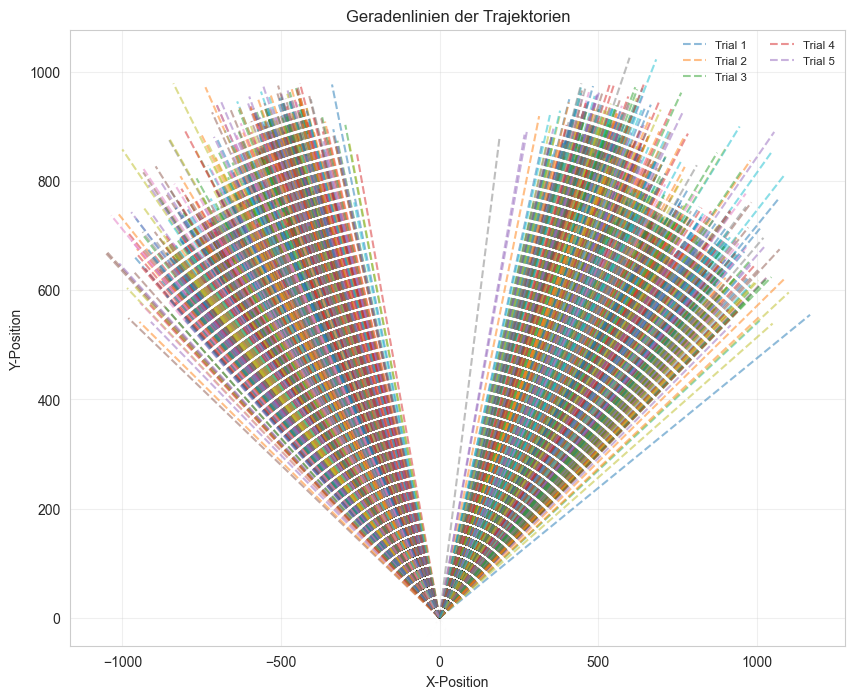

In [121]:
visualize_trajectories(combined_with_latency_final_preprocessed)

### Effekte von Kongruenz auf Krümmungsgrad (ANOVA)

#### Unterschiede zwischen Conditions auf Krümmungsgrad

In [122]:
mean_curvature_with_latency = combined_with_latency_final_preprocessed.groupby('participant_num')['normalized_curvature'].mean()
mean_curvature_no_latency = combined_no_latency_final_preprocessed.groupby('participant_num')['normalized_curvature'].mean()

comparison_df_curvature = pd.DataFrame({
    'participant_num': mean_curvature_with_latency.index,
    'curvature_with_latency': mean_curvature_with_latency.values,
    'curvature_no_latency': mean_curvature_no_latency.values
})

# Calculate difference scores
comparison_df_curvature['curvature_difference'] = comparison_df_curvature['curvature_with_latency'] - comparison_df_curvature['curvature_no_latency']

# Run paired t-test
t_stat, p_value = ttest_rel(comparison_df_curvature['curvature_with_latency'], comparison_df_curvature['curvature_no_latency'])
 

In [123]:
# Print results
print("Paired Samples T-Test Results:")
print("-" * 40)
print(f"Mean curvature degree (With Latency): {comparison_df_curvature['curvature_with_latency'].mean():.2f} degrees")
print(f"Mean curvature degree (No Latency): {comparison_df_curvature['curvature_no_latency'].mean():.2f} degrees")
print(f"Mean difference: {comparison_df_curvature['curvature_difference'].mean():.2f} degrees")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")

# Effect size (Cohen's d for paired samples)
cohens_d = (comparison_df_curvature['curvature_difference'].mean() / 
            comparison_df_curvature['curvature_difference'].std())
print(f"Effect size (Cohen's d): {cohens_d:.4f}")

Paired Samples T-Test Results:
----------------------------------------
Mean curvature degree (With Latency): 18.17 degrees
Mean curvature degree (No Latency): 17.56 degrees
Mean difference: 0.61 degrees
t-statistic: 2.6025
p-value: 0.02190149
Significant difference: Yes (α = 0.05)
Effect size (Cohen's d): 0.6955


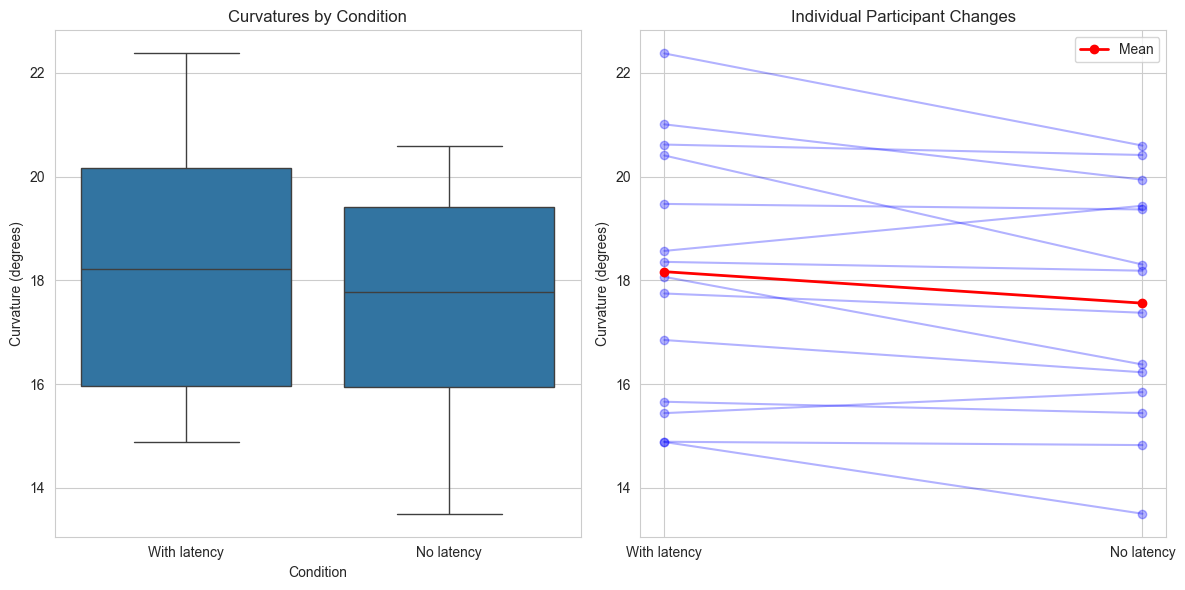

In [124]:
# Visualize the results
plt.figure(figsize=(12, 6))

# 1. Create a boxplot comparing conditions
plt.subplot(1, 2, 1)
comparison_long = pd.melt(comparison_df_curvature, 
                          id_vars=['participant_num'], 
                          value_vars=['curvature_with_latency', 'curvature_no_latency'],
                          var_name='condition', value_name='curvature degrees')
sns.boxplot(x='condition', y='curvature degrees', data=comparison_long)
plt.title('Curvatures by Condition')
plt.xlabel('Condition')
plt.ylabel('Curvature (degrees)')
plt.xticks([0, 1], ['With latency', 'No latency'])

# 2. Create a paired plot showing individual differences
plt.subplot(1, 2, 2)
for i, row in comparison_df_curvature.iterrows():
    plt.plot([1, 2], [row['curvature_with_latency'], row['curvature_no_latency']], 
             'o-', alpha=0.3, color='blue')

plt.plot([1, 2], [comparison_df_curvature['curvature_with_latency'].mean(), 
                  comparison_df_curvature['curvature_no_latency'].mean()], 
         'o-', linewidth=2, color='red', label='Mean')

plt.title('Individual Participant Changes')
plt.ylabel('Curvature (degrees)')
plt.xticks([1, 2], ['With latency', 'No latency'])
plt.legend()

plt.tight_layout()
plt.show()

#### Mit Latenz

In [125]:
#need to aggregate because each participant has multiple trials with same conditions
aggregated_df_with_latency_curvature = combined_with_latency_final_preprocessed.groupby(['participant_num', 'currentcongruency', 'previouscongruency'])['normalized_curvature'].mean().reset_index()

aovrm = AnovaRM(aggregated_df_with_latency_curvature, 'normalized_curvature', 'participant_num', within=['currentcongruency', 'previouscongruency'])
anova_res_with_latency_curvature = aovrm.fit()

print(anova_res_with_latency_curvature.summary())

                              Anova
                                     F Value Num DF  Den DF Pr > F
------------------------------------------------------------------
currentcongruency                     1.3983 1.0000 13.0000 0.2582
previouscongruency                   14.9718 1.0000 13.0000 0.0019
currentcongruency:previouscongruency  5.4468 1.0000 13.0000 0.0363



In [126]:
# Extract and print p-values specifically
print("\nANOVA Results - Congruency on Curvature (with latency):")
print("-" * 50)
results_df_with_latency_curvature = anova_res_with_latency_curvature.anova_table
print(f"Current Congruency Effect: F({results_df_with_latency_curvature.loc['currentcongruency', 'Num DF']:.1f}, {results_df_with_latency_curvature.loc['currentcongruency', 'Den DF']:.1f}) = {results_df_with_latency_curvature.loc['currentcongruency', 'F Value']:.2f}, p = {results_df_with_latency_curvature.loc['currentcongruency', 'Pr > F']:.6f}")
print(f"Previous Congruency Effect: F({results_df_with_latency_curvature.loc['previouscongruency', 'Num DF']:.1f}, {results_df_with_latency_curvature.loc['previouscongruency', 'Den DF']:.1f}) = {results_df_with_latency_curvature.loc['previouscongruency', 'F Value']:.2f}, p = {results_df_with_latency_curvature.loc['previouscongruency', 'Pr > F']:.6f}")
print(f"Interaction Effect: F({results_df_with_latency_curvature.loc['currentcongruency:previouscongruency', 'Num DF']:.1f}, {results_df_with_latency_curvature.loc['currentcongruency:previouscongruency', 'Den DF']:.1f}) = {results_df_with_latency_curvature.loc['currentcongruency:previouscongruency', 'F Value']:.2f}, p = {results_df_with_latency_curvature.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")


ANOVA Results - Congruency on Curvature (with latency):
--------------------------------------------------
Current Congruency Effect: F(1.0, 13.0) = 1.40, p = 0.258183
Previous Congruency Effect: F(1.0, 13.0) = 14.97, p = 0.001935
Interaction Effect: F(1.0, 13.0) = 5.45, p = 0.03630198


In [127]:
aggregated_df_with_latency_curvature['curvature_zscore'] = zscore(aggregated_df_with_latency_curvature['normalized_curvature'])

condition_means_with_latency_curvature = aggregated_df_with_latency_curvature.groupby(['currentcongruency', 'previouscongruency'])['normalized_curvature'].mean().reset_index()

print("\nAnova results for congruency (current/previous) on curvature (With latency):")
print("\nMean Reaction Times for Each Condition:")
print("-" * 50)
for _, row in condition_means_with_latency_curvature.iterrows():
    current = "Congruent" if row['currentcongruency'] == 1 else "Incongruent"
    previous = "Congruent" if row['previouscongruency'] == 1 else "Incongruent"
    print(f"Previous: {previous:<11} Current: {current:<11} Mean curvature: {row['normalized_curvature']:.2f} degree")

# Calculate main effects
print("\nMain Effects:")
print("-" * 50)
current_effect = condition_means_with_latency_curvature.groupby('currentcongruency')['normalized_curvature'].mean()
print(f"Current Congruency Effect: Incongruent: {current_effect[0]:.2f} degree, Congruent: {current_effect[1]:.2f} degree")
print(f"Congruency Effect Size: {current_effect[0] - current_effect[1]:.2f} degree")
print(f"Statistical Significance: p = {results_df_with_latency_curvature.loc['currentcongruency', 'Pr > F']:.6f}\n")

previous_effect = condition_means_with_latency_curvature.groupby('previouscongruency')['normalized_curvature'].mean()
print(f"Previous Congruency Effect: Incongruent: {previous_effect[0]:.2f} degree, Congruent: {previous_effect[1]:.2f} degree")
print(f"Previous Trial Effect Size: {previous_effect[0] - previous_effect[1]:.2f} degree")
print(f"Statistical Significance: p = {results_df_with_latency_curvature.loc['previouscongruency', 'Pr > F']:.6f}\n")

# Examine the interaction
cc_effect_after_c = condition_means_with_latency_curvature[condition_means_with_latency_curvature['previouscongruency']==1]['normalized_curvature'].values
cc_effect_after_c = cc_effect_after_c[0] - cc_effect_after_c[1] if len(cc_effect_after_c) > 1 else "N/A"

cc_effect_after_ic = condition_means_with_latency_curvature[condition_means_with_latency_curvature['previouscongruency']==0]['normalized_curvature'].values
cc_effect_after_ic = cc_effect_after_ic[0] - cc_effect_after_ic[1] if len(cc_effect_after_ic) > 1 else "N/A"

print("Interaction:")
print("-" * 50)
print(f"Congruency effect after congruent trial: {cc_effect_after_c:.2f} degree")
print(f"Congruency effect after incongruent trial: {cc_effect_after_ic:.2f} degree")
print(f"Difference in congruency effects (Gratton Effect size): {cc_effect_after_c - cc_effect_after_ic:.2f} degree")
print(f"Statistical Significance: p = {results_df_with_latency_curvature.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")




Anova results for congruency (current/previous) on curvature (With latency):

Mean Reaction Times for Each Condition:
--------------------------------------------------
Previous: Incongruent Current: Incongruent Mean curvature: 18.66 degree
Previous: Congruent   Current: Incongruent Mean curvature: 17.97 degree
Previous: Incongruent Current: Congruent   Mean curvature: 18.11 degree
Previous: Congruent   Current: Congruent   Mean curvature: 17.97 degree

Main Effects:
--------------------------------------------------
Current Congruency Effect: Incongruent: 18.32 degree, Congruent: 18.04 degree
Congruency Effect Size: 0.28 degree
Statistical Significance: p = 0.258183

Previous Congruency Effect: Incongruent: 18.39 degree, Congruent: 17.97 degree
Previous Trial Effect Size: 0.42 degree
Statistical Significance: p = 0.001935

Interaction:
--------------------------------------------------
Congruency effect after congruent trial: 0.01 degree
Congruency effect after incongruent trial: 0.5

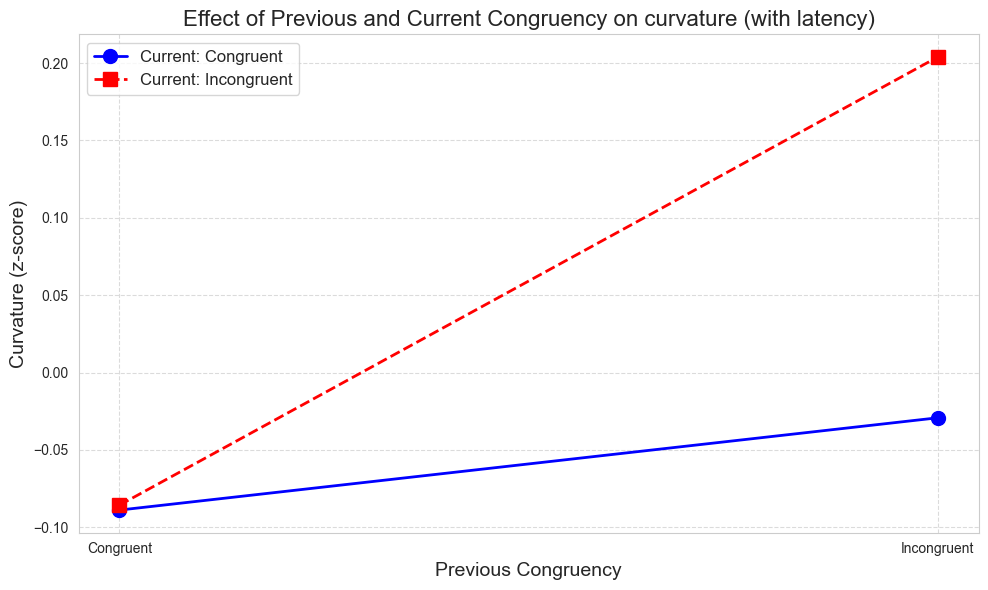

In [128]:
aggregated_df_with_latency_curvature['curvature_zscore'] = zscore(aggregated_df_with_latency_curvature['normalized_curvature'])

visualize_anova_results(aggregated_df_with_latency_curvature, "curvature_zscore", "Curvature (z-score)", "Effect of Previous and Current Congruency on curvature (with latency)", False)     

#### ohne Latenz

In [129]:
#need to aggregate because each participant has multiple trials with same conditions
aggregated_df_no_latency_curvature = combined_no_latency_final_preprocessed.groupby(['participant_num', 'currentcongruency', 'previouscongruency'])['normalized_curvature'].mean().reset_index()

aovrm = AnovaRM(aggregated_df_no_latency_curvature, 'normalized_curvature', 'participant_num', within=['currentcongruency', 'previouscongruency'])
anova_res_no_latency_curvature = aovrm.fit()

print(anova_res_no_latency_curvature.summary())

                              Anova
                                     F Value Num DF  Den DF Pr > F
------------------------------------------------------------------
currentcongruency                    25.4876 1.0000 13.0000 0.0002
previouscongruency                    0.2138 1.0000 13.0000 0.6515
currentcongruency:previouscongruency  0.5600 1.0000 13.0000 0.4676



In [130]:
# Extract and print p-values specifically
print("\nANOVA Results - Congruency on Curvature (no latency):")
print("-" * 50)
results_df_no_latency_curvature = anova_res_no_latency_curvature.anova_table
print(f"Current Congruency Effect: F({results_df_no_latency_curvature.loc['currentcongruency', 'Num DF']:.1f}, {results_df_no_latency_curvature.loc['currentcongruency', 'Den DF']:.1f}) = {results_df_no_latency_curvature.loc['currentcongruency', 'F Value']:.2f}, p = {results_df_no_latency_curvature.loc['currentcongruency', 'Pr > F']:.6f}")
print(f"Previous Congruency Effect: F({results_df_no_latency_curvature.loc['previouscongruency', 'Num DF']:.1f}, {results_df_no_latency_curvature.loc['previouscongruency', 'Den DF']:.1f}) = {results_df_no_latency_curvature.loc['previouscongruency', 'F Value']:.2f}, p = {results_df_no_latency_curvature.loc['previouscongruency', 'Pr > F']:.6f}")
print(f"Interaction Effect: F({results_df_no_latency_curvature.loc['currentcongruency:previouscongruency', 'Num DF']:.1f}, {results_df_no_latency_curvature.loc['currentcongruency:previouscongruency', 'Den DF']:.1f}) = {results_df_no_latency_curvature.loc['currentcongruency:previouscongruency', 'F Value']:.2f}, p = {results_df_no_latency_curvature.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")


ANOVA Results - Congruency on Curvature (no latency):
--------------------------------------------------
Current Congruency Effect: F(1.0, 13.0) = 25.49, p = 0.000223
Previous Congruency Effect: F(1.0, 13.0) = 0.21, p = 0.651464
Interaction Effect: F(1.0, 13.0) = 0.56, p = 0.46759757


In [131]:
# Calculate and print mean values for each condition
condition_means_no_latency_curvature = aggregated_df_no_latency_curvature.groupby(['currentcongruency', 'previouscongruency'])['normalized_curvature'].mean().reset_index()

print("\nAnova results for congruency (current/previous) on curvature (no latency):")
print("\nMean Reaction Times for Each Condition:")
print("-" * 50)
for _, row in condition_means_no_latency_curvature.iterrows():
    current = "Congruent" if row['currentcongruency'] == 1 else "Incongruent"
    previous = "Congruent" if row['previouscongruency'] == 1 else "Incongruent"
    print(f"Previous: {previous:<11} Current: {current:<11} Mean RT: {row['normalized_curvature']:.2f} degree")

# Calculate main effects
print("\nMain Effects:")
print("-" * 50)
current_effect = condition_means_no_latency_curvature.groupby('currentcongruency')['normalized_curvature'].mean()
print(f"Current Congruency Effect: Incongruent: {current_effect[0]:.2f} degree, Congruent: {current_effect[1]:.2f} degree")
print(f"Congruency Effect Size: {current_effect[0] - current_effect[1]:.2f} degree")
print(f"Statistical Significance: p = {results_df_no_latency_curvature.loc['currentcongruency', 'Pr > F']:.6f}\n")

previous_effect = condition_means_no_latency_curvature.groupby('previouscongruency')['normalized_curvature'].mean()
print(f"Previous Congruency Effect: Incongruent: {previous_effect[0]:.2f} degree, Congruent: {previous_effect[1]:.2f} degree")
print(f"Previous Trial Effect Size: {previous_effect[0] - previous_effect[1]:.2f} degree")
print(f"Statistical Significance: p = {results_df_no_latency_curvature.loc['previouscongruency', 'Pr > F']:.6f}\n")

# Examine the interaction 
cc_effect_after_c = condition_means_no_latency_curvature[condition_means_no_latency_curvature['previouscongruency']==1]['normalized_curvature'].values
cc_effect_after_c = cc_effect_after_c[0] - cc_effect_after_c[1] if len(cc_effect_after_c) > 1 else "N/A"

cc_effect_after_ic = condition_means_no_latency_curvature[condition_means_no_latency_curvature['previouscongruency']==0]['normalized_curvature'].values
cc_effect_after_ic = cc_effect_after_ic[0] - cc_effect_after_ic[1] if len(cc_effect_after_ic) > 1 else "N/A"

print("Interaction:")
print("-" * 50)
print(f"Congruency effect after congruent trial: {cc_effect_after_c:.2f} degree")
print(f"Congruency effect after incongruent trial: {cc_effect_after_ic:.2f} degree")
print(f"Difference in congruency effects (Effect size): {cc_effect_after_c - cc_effect_after_ic:.2f} degree")
print(f"Statistical Significance: p = {results_df_no_latency_curvature.loc['currentcongruency:previouscongruency', 'Pr > F']:.8f}")




Anova results for congruency (current/previous) on curvature (no latency):

Mean Reaction Times for Each Condition:
--------------------------------------------------
Previous: Incongruent Current: Incongruent Mean RT: 18.44 degree
Previous: Congruent   Current: Incongruent Mean RT: 18.47 degree
Previous: Incongruent Current: Congruent   Mean RT: 16.78 degree
Previous: Congruent   Current: Congruent   Mean RT: 16.66 degree

Main Effects:
--------------------------------------------------
Current Congruency Effect: Incongruent: 18.45 degree, Congruent: 16.72 degree
Congruency Effect Size: 1.74 degree
Statistical Significance: p = 0.000223

Previous Congruency Effect: Incongruent: 17.61 degree, Congruent: 17.56 degree
Previous Trial Effect Size: 0.04 degree
Statistical Significance: p = 0.651464

Interaction:
--------------------------------------------------
Congruency effect after congruent trial: 1.82 degree
Congruency effect after incongruent trial: 1.66 degree
Difference in congrue

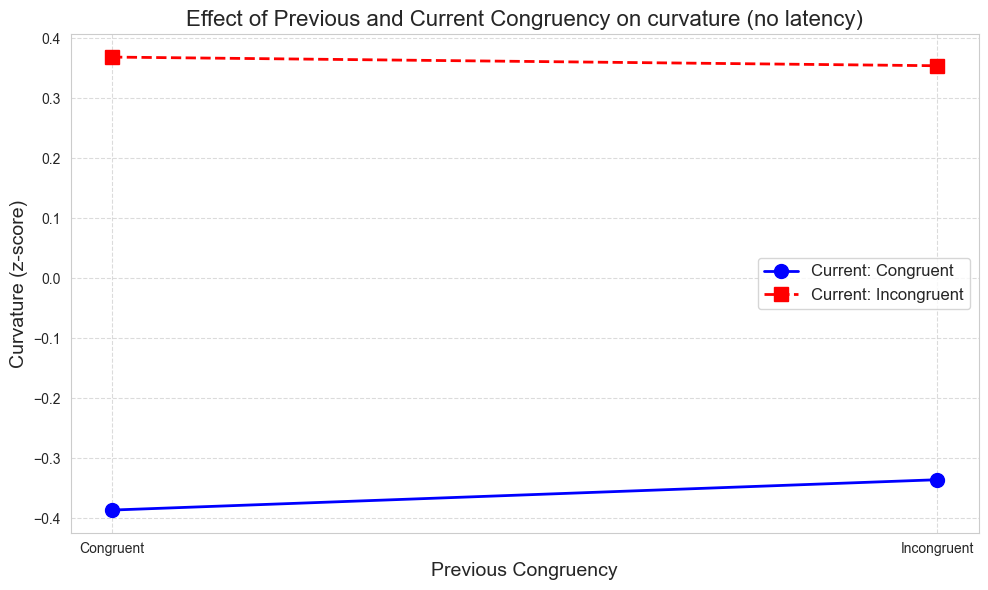

In [132]:
aggregated_df_no_latency_curvature['curvature_zscore'] = zscore(aggregated_df_no_latency_curvature['normalized_curvature'])

visualize_anova_results(aggregated_df_no_latency_curvature, "curvature_zscore", "Curvature (z-score)", "Effect of Previous and Current Congruency on curvature (no latency)", False)     

### Jedem Trial ein "slow_trial" hinzufügen, welches anhand der median RT gegeben wird. (Langsamer Trial = 1; Schneller Trial = 0)

In [133]:
combined_no_latency_final_preprocessed["reactiontime"] = pd.to_numeric(combined_no_latency_final_preprocessed["reactiontime"])
combined_no_latency_final_preprocessed["median_rt"] = combined_no_latency_final_preprocessed.groupby("participant_num")["reactiontime"].transform("median")
combined_no_latency_final_preprocessed["slow_trial"] = (combined_no_latency_final_preprocessed["reactiontime"] > combined_no_latency_final_preprocessed["median_rt"]).astype(int)

combined_with_latency_final_preprocessed["reactiontime"] = pd.to_numeric(combined_with_latency_final_preprocessed["reactiontime"])
combined_with_latency_final_preprocessed["median_rt"] = combined_with_latency_final_preprocessed.groupby("participant_num")["reactiontime"].transform("median")
combined_with_latency_final_preprocessed["slow_trial"] = (combined_with_latency_final_preprocessed["reactiontime"] > combined_with_latency_final_preprocessed["median_rt"]).astype(int)

combined_no_latency_final_preprocessed.head()

,trialnumber,blocknumber,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation,participant_num,timedifference,xpos,ypos,curvature,trajectory_length,normalized_curvature,normalized_curvature_minmax,median_rt,slow_trial
0,1,3,1,396,0,1,0,0,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, -0.38383838383838426, -1....","[0.0, 11.171717171717173, 22.343434343434346, ...",25230.707071,1253.513624,20.127988,0.537479,400.0,0
1,2,3,1,402,0,0,1,0,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 6.464646464646465, 14.161616161616163, 2...","[0.0, 4.040404040404041, 9.92929292929293, 16....",33860.272727,1368.411512,24.744218,0.665961,400.0,1
2,3,3,1,396,0,0,1,0,0,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.595959595959596, 3.191919191919192, 4....","[0.0, 5.5858585858585865, 12.363636363636365, ...",29520.818182,1526.851628,19.334438,0.515393,400.0,0
3,4,3,1,266,1,0,0,0,0,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.0707070707070707, -2.141414141414142,...","[0.0, 2.676767676767677, 5.636363636363638, 10...",15266.888889,835.405529,18.274824,0.485901,400.0,0
4,5,3,1,496,1,1,1,1,0,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -2.0, -2.0, -4.0, -4.0, -5.0, -5.0, -7.0...","[0.0, 1.0, 4.0, 5.0, 8.0, 9.0, 12.0, 13.0, 15....",13961.000000,1278.320206,10.921364,0.281236,400.0,1


#### 4 Prädikatoren

direction(n) = **currentdirection** (1 = right; 0 = left) </br>
location(n) = **currentlocation** (1 = right; 0 = left) </br>
response(n - 1) = reflects previous (correct) response and hence the **previousdirection** (1 = right; 0 = left) </br>
congruency(n - 1) reflects the expected influence of the direction(n - 1)/location(n - 1), **previouscongruency** (1 = congruent, 0 = incongruent) 

In [134]:
def compute_trajectory_angles(xpos, ypos):
    if len(xpos) < 2 or len(ypos) < 2:
        return np.nan  
    
    x_array = np.array(xpos)
    y_array = np.array(ypos)

    delta_x = np.diff(x_array)  
    delta_y = np.diff(y_array)  
    
    # Compute angles relative to Y-axis
    angles_rad = np.arctan2(delta_x, delta_y)  
    
    # Normalize angles between -1 and 1
    angles_normalized = angles_rad / np.pi
    
    return angles_normalized.tolist()  

Umwandeln von 0ern der Prädikatoren in -1 Werte

In [135]:
predictor_columns = ["currentdirection", "currentlocation", "previousdirection", "previouscongruency"]

combined_no_latency_final_preprocessed[predictor_columns] = combined_no_latency_final_preprocessed[predictor_columns].replace(0, -1)
combined_with_latency_final_preprocessed[predictor_columns] = combined_with_latency_final_preprocessed[predictor_columns].replace(0, -1)

combined_no_latency_final_preprocessed.head()

,trialnumber,blocknumber,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation,participant_num,timedifference,xpos,ypos,curvature,trajectory_length,normalized_curvature,normalized_curvature_minmax,median_rt,slow_trial
0,1,3,1,396,0,1,-1,-1,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, -0.38383838383838426, -1....","[0.0, 11.171717171717173, 22.343434343434346, ...",25230.707071,1253.513624,20.127988,0.537479,400.0,0
1,2,3,1,402,0,-1,1,-1,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 6.464646464646465, 14.161616161616163, 2...","[0.0, 4.040404040404041, 9.92929292929293, 16....",33860.272727,1368.411512,24.744218,0.665961,400.0,1
2,3,3,1,396,0,-1,1,-1,-1,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.595959595959596, 3.191919191919192, 4....","[0.0, 5.5858585858585865, 12.363636363636365, ...",29520.818182,1526.851628,19.334438,0.515393,400.0,0
3,4,3,1,266,1,-1,-1,-1,-1,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.0707070707070707, -2.141414141414142,...","[0.0, 2.676767676767677, 5.636363636363638, 10...",15266.888889,835.405529,18.274824,0.485901,400.0,0
4,5,3,1,496,1,1,1,1,-1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -2.0, -2.0, -4.0, -4.0, -5.0, -5.0, -7.0...","[0.0, 1.0, 4.0, 5.0, 8.0, 9.0, 12.0, 13.0, 15....",13961.000000,1278.320206,10.921364,0.281236,400.0,1


#### Berechnen der Trajectory Angles (100 Zeitschritte)

In [136]:
combined_no_latency_final_preprocessed["trajectory_angle"] = combined_no_latency_final_preprocessed.apply(lambda row: compute_trajectory_angles(row["xpos"], row["ypos"]), axis=1)
combined_with_latency_final_preprocessed["trajectory_angle"] = combined_with_latency_final_preprocessed.apply(lambda row: compute_trajectory_angles(row["xpos"], row["ypos"]), axis=1)

print(combined_no_latency_final_preprocessed["trajectory_angle"].iloc[0]) 
print(combined_with_latency_final_preprocessed["trajectory_angle"].iloc[0]) 

[0.0, 0.0, 0.0, -0.011958540456714366, -0.06960448727306393, -0.06298636053191246, -0.01980971959788098, -0.11454548957280279, -0.25939882537924736, 0.0, -0.2380689698427858, -0.09742520095620845, -0.1596655293982666, -0.2389834881151767, -0.20483276469913356, -0.10834693614812307, -0.18388561284073984, -0.20997787377357782, -0.21984390452160765, -0.2499999999999993, -0.2500000000000007, -0.22666798624647247, -0.231688244596965, -0.2570515025248739, -0.2788579383763045, -0.2545340221976979, -0.24999999999999778, 0.0, 0.0, 0.0, 0.23744165604921483, 0.36718542570760054, 0.3571943473983582, 0.3241555954522046, 0.3055998877857848, 0.23219881787003982, 0.24067111170153946, 0.1807680226635889, 0.009382339984868822, 0.0525684567112535, 0.007668633741357628, 0.0, -0.05885313502045133, -0.12722793095810522, -0.09277357907774236, -0.15257745622457583, -0.13858919622156252, -0.13670356894997035, -0.1496240376912004, -0.16524934053856805, -0.13652782806909744, -0.16039201831743957, -0.171453725659

#### Berechnen der Beta-Gewichte und Grand averages

In [166]:
def get_beta_weights_per_participant(df):
    x = df[predictor_columns].values
    x = sm.add_constant(x)

    participant_ids = df["participant_num"].unique()
    beta_weights_per_participant = {p_id: np.zeros((4, 100)) for p_id in participant_ids}

    for participant in participant_ids:
        participant_trials = df[df["participant_num"] == participant]
        traj_matrix = np.array(participant_trials["trajectory_angle"].tolist())

        x_participant = participant_trials[predictor_columns].values
        x_participant = sm.add_constant(x_participant)

        for t in range(99):
            y = traj_matrix[:, t]

            if y.shape[0] < 2:
                continue

            model = sm.OLS(y, x_participant).fit()
            beta_weights_per_participant[participant][:, t] = model.params[1:]

    return beta_weights_per_participant

def get_mean_times_per_participant(df):
    return df.groupby("participant_num")["reactiontime"].mean().reset_index()
    
def trajectory_angle_multiple_regression(df):
    beta_weights_per_participant = get_beta_weights_per_participant(df)
    
    beta_avg = np.mean(np.array(list(beta_weights_per_participant.values())), axis = 0)

    beta_df = pd.DataFrame(beta_avg.T, columns=predictor_columns)

    return beta_df

In [167]:
# Splitting into slow and fast bins
combined_with_latency_fast = combined_with_latency_final_preprocessed[combined_with_latency_final_preprocessed["slow_trial"] == 0]
combined_with_latency_slow = combined_with_latency_final_preprocessed[combined_with_latency_final_preprocessed["slow_trial"] == 1]

combined_no_latency_fast = combined_no_latency_final_preprocessed[combined_no_latency_final_preprocessed["slow_trial"] == 0]
combined_no_latency_slow = combined_no_latency_final_preprocessed[combined_no_latency_final_preprocessed["slow_trial"] == 1]

In [168]:
beta_weights_per_participant_with_latency_fast = get_beta_weights_per_participant(combined_with_latency_fast)
beta_weights_per_participant_with_latency_slow = get_beta_weights_per_participant(combined_with_latency_slow)
beta_weights_per_participant_no_latency_fast = get_beta_weights_per_participant(combined_no_latency_fast)
beta_weights_per_participant_no_latency_slow = get_beta_weights_per_participant(combined_no_latency_slow)

mean_reactiontimes_per_participant_with_latency_fast = get_mean_times_per_participant(combined_with_latency_fast)
mean_reactiontimes_per_participant_with_latency_slow = get_mean_times_per_participant(combined_with_latency_slow)
mean_reactiontimes_per_participant_no_latency_fast = get_mean_times_per_participant(combined_no_latency_fast)
mean_reactiontimes_per_participant_no_latency_slow = get_mean_times_per_participant(combined_no_latency_fast)

beta_weights_with_latency_fast = trajectory_angle_multiple_regression(combined_with_latency_fast)
beta_weights_with_latency_slow = trajectory_angle_multiple_regression(combined_with_latency_slow)
beta_weights_no_latency_fast = trajectory_angle_multiple_regression(combined_no_latency_fast)
beta_weights_no_latency_slow = trajectory_angle_multiple_regression(combined_no_latency_slow)

beta_weights_all = [{"weights": beta_weights_with_latency_fast, "label": "with latency (fast trials)"}, {"weights": beta_weights_with_latency_slow, "label": "with latency (slow trials)"},
{"weights": beta_weights_no_latency_fast, "label": "without latency (fast trials)"}, {"weights": beta_weights_no_latency_slow, "label": "without latency (slow trials)"}]

In [140]:
mean_reactiontimes_per_participant_no_latency_fast

,participant_num,reactiontime
0,1,338.899676
1,2,381.560403
2,3,377.990228
3,4,378.933110
4,5,372.291139
5,6,376.827362
6,7,360.959732
7,8,356.627586
8,9,332.358423
9,10,390.993590


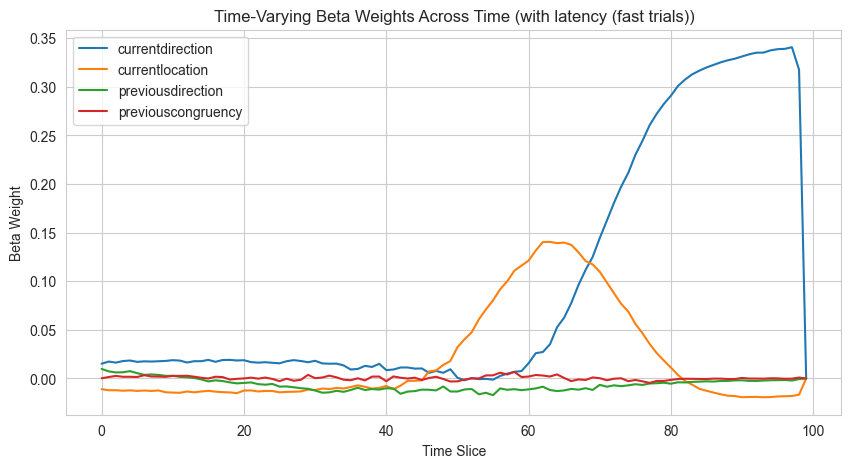

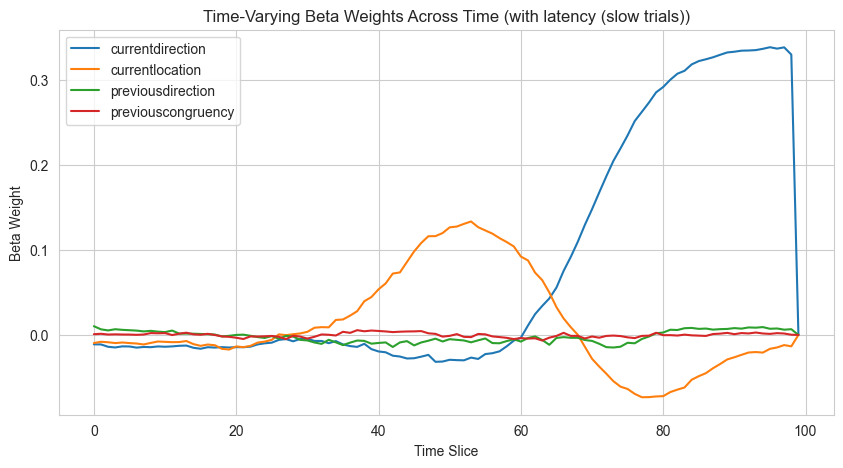

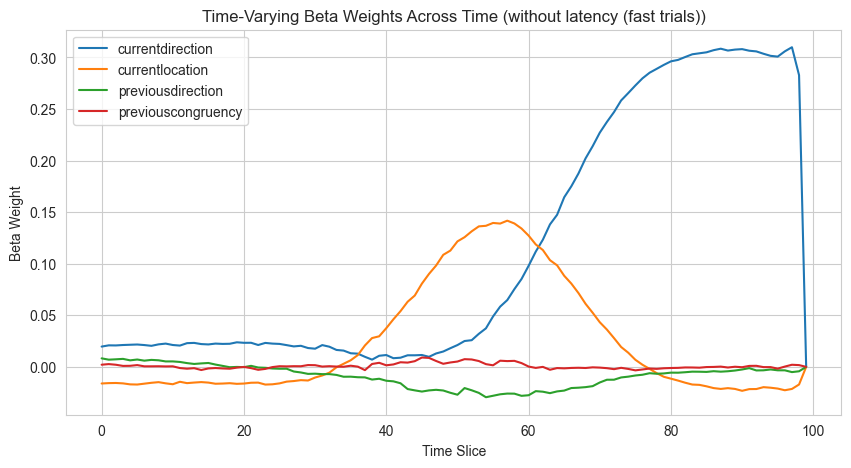

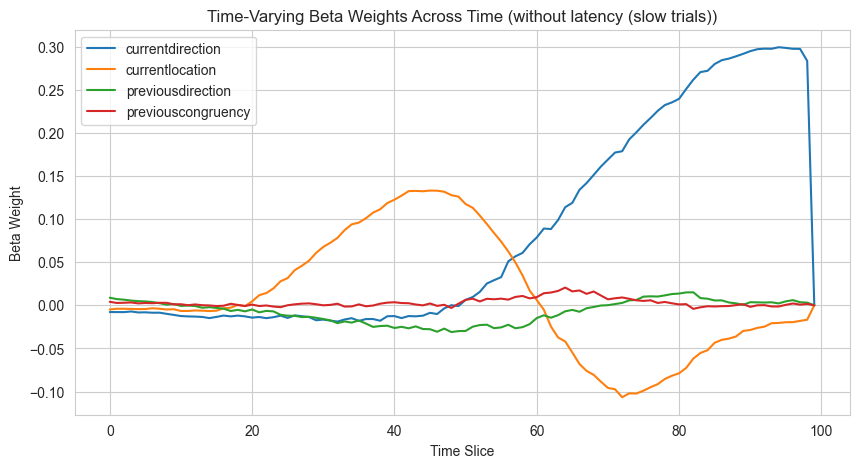

In [ ]:
for beta_weights in beta_weights_all:
    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.plot(beta_weights["weights"].index, beta_weights["weights"].iloc[:, i], label=f"{predictor_columns[i]}")
    plt.xlabel("Time Slice")
    plt.ylabel("Beta Weight")
    plt.legend()
    plt.title(f"Time-Varying Beta Weights Across Time ({beta_weights['label']})")
    plt.show()


#### get peaks (values and indices)

In [142]:
def get_peak_values_and_indices(df, condition_label):
    beta_weights_np = df.to_numpy()

    peak_beta_values = np.max(beta_weights_np, axis = 0)
    peak_beta_indices = np.argmax(beta_weights_np, axis = 0)

    for i, pred in enumerate(predictor_columns):
        print(f"{pred} ({condition_label}): Peak at slice: {peak_beta_indices[i] + 1} (value: {peak_beta_values[i]})") 


In [143]:
get_peak_values_and_indices(beta_weights_with_latency_fast, "With latency (fast)")
print("\n")

get_peak_values_and_indices(beta_weights_with_latency_slow, "With latency (slow)")
print("\n")

get_peak_values_and_indices(beta_weights_no_latency_fast, "No latency (fast)")
print("\n")

get_peak_values_and_indices(beta_weights_no_latency_slow, "No latency (slow)")

currentdirection (With latency (fast)): Peak at slice: 98 (value: 0.34077839124359616)
currentlocation (With latency (fast)): Peak at slice: 64 (value: 0.1405665997578363)
previousdirection (With latency (fast)): Peak at slice: 1 (value: 0.009806506038822037)
previouscongruency (With latency (fast)): Peak at slice: 59 (value: 0.0067660061544698585)


currentdirection (With latency (slow)): Peak at slice: 96 (value: 0.33887717168670883)
currentlocation (With latency (slow)): Peak at slice: 54 (value: 0.13364657397251775)
previousdirection (With latency (slow)): Peak at slice: 1 (value: 0.010297821133262238)
previouscongruency (With latency (slow)): Peak at slice: 38 (value: 0.0056093264685483915)


currentdirection (No latency (fast)): Peak at slice: 98 (value: 0.3097906864742056)
currentlocation (No latency (fast)): Peak at slice: 58 (value: 0.141689610369806)
previousdirection (No latency (fast)): Peak at slice: 1 (value: 0.008253571698370172)
previouscongruency (No latency (fast)): P

### Replikations-Tests für Krümmungswinkel (T-tests against zero & paired t-tests)

In [156]:
def get_peak_times(df_times, slice_factor, included_participants="all"):
    if included_participants != "all":
        df = df_times[df_times["participant_num"].isin(included_participants)]
    else: 
        df = df_times

    # Compute mean reaction time
    mean_rt = df["reactiontime"].mean()
    
    # Scale mean reaction time by the given factor (convert factor to 0.01 - 1 range)
    scaled_mean_rt = mean_rt * (slice_factor / 100)
    
    return scaled_mean_rt
    

def analyze_beta_weights_jackknife(subject_beta_weights_cond1, subject_beta_weights_cond2, subject_times_cond1, subject_times_cond2, condition_1_label, condition_2_label):    
    n_subjects = len(subject_beta_weights_cond1)
    n_predictors = subject_beta_weights_cond1[1].shape[0]
    n_timepoints = subject_beta_weights_cond1[1].shape[1]
    
    # Dictionary to store results
    results = {condition_1_label: {}, condition_2_label: {}}
    
    # Process each condition
    for condition_name, subject_data in [(condition_1_label, subject_beta_weights_cond1), 
                                         (condition_2_label, subject_beta_weights_cond2)]:
        if condition_name == condition_1_label:
            condition_times = subject_times_cond1
        else:
            condition_times = subject_times_cond2
            
        #print(subject_data[1][0][0])
        # Calculate grand average across all subjects for each predictor
        #grand_avg = np.zeros((n_predictors, n_timepoints))
        
        #print(subject_data[1][0])
        #for subject in subject_data:
            #for subject_arr in subject_data[subject]:
                #grand_avg += subject_arr
            
        #grand_avg /= n_subjects

        #beta_avg = np.mean(np.array(list(beta_weights_per_participant.values())), axis = 0)
        
        # Analyze each predictor
        for pred_idx, predictor_name in enumerate(predictor_columns):
            # Extract beta weights for this predictor from grand average

            grand_avg = np.zeros((1, n_timepoints))

            for subject in subject_data:
                grand_avg += subject_data[subject][pred_idx]
            
            grand_avg /= n_subjects

            beta_weights_pred = grand_avg[0]
            #print(beta_weights_pred)
            
            # Find peak in grand average (maximum absolute beta)
            peak_idx = np.argmax(beta_weights_pred)
            peak_beta = beta_weights_pred[peak_idx]
            peak_time = get_peak_times(condition_times, peak_idx+1)
            
            # Perform jackknifing
            jackknife_peaks = []
            jackknife_times = []
            jackknife_beta_at_peak = []
            
            for leave_out in range(n_subjects):
                # Create jackknife sample by leaving one subject out
                jk_avg = np.zeros((1, n_timepoints))
                included_subjects = [s for i, s in enumerate(subject_data) if i != leave_out]
            

                for subject in included_subjects:
                    jk_avg += subject_data[subject][pred_idx]
                
                jk_avg /= len(included_subjects)
                
                # Get beta weights for this predictor in jackknife sample
                jk_betas = jk_avg[0]
                
                # Find peak in jackknife sample
                jk_peak_idx = np.argmax(jk_betas)
                jackknife_peaks.append(jk_betas[jk_peak_idx])
                jackknife_times.append(get_peak_times(condition_times, jk_peak_idx+1, included_subjects))
                
                # Also get beta at the original peak time for variance estimation
                jackknife_beta_at_peak.append(jk_betas[peak_idx])
            
            # Calculate SE using jackknife estimates at the original peak time
            se_peak = sem(jackknife_beta_at_peak)
            
            # One-sample t-test against zero
            t_stat = peak_beta / se_peak
            df_t = n_subjects - 1
            p_value = 2 * (1 - t.cdf(abs(t_stat), df_t))  # Two-tailed
            
            # Store results
            results[condition_name][predictor_name] = {
                'peak_slice': peak_idx,
                'peak_time_ms': peak_time,
                'peak_beta': peak_beta,
                'se_beta': se_peak,
                't_statistic': t_stat,
                'p_value': p_value,
                'df': df_t,
                'jackknife_beta_values': jackknife_beta_at_peak,
                'jackknife_peak_times': jackknife_times
            }
    
    # Compare conditions with paired t-tests
    results['comparisons'] = {}
    for pred_idx, predictor_name in enumerate(predictor_columns):
        # Compare peak times between conditions
        time_diffs = []
        beta_diffs = []
        
        for i in range(n_subjects):
            # For each jackknife sample, get timing and beta differences
            time1 = results[condition_1_label][predictor_name]['jackknife_peak_times'][i]
            time2 = results[condition_2_label][predictor_name]['jackknife_peak_times'][i]
            time_diffs.append(time1 - time2)
            
            beta1 = results[condition_1_label][predictor_name]['jackknife_beta_values'][i]
            beta2 = results[condition_2_label][predictor_name]['jackknife_beta_values'][i]
            beta_diffs.append(beta1 - beta2)
        
        # Calculate statistics for timing differences
        mean_time_diff = np.mean(time_diffs)
        se_time_diff = sem(time_diffs)
        t_stat_time = mean_time_diff / se_time_diff if se_time_diff > 0 else 0
        p_value_time = 2 * (1 - t.cdf(abs(t_stat_time), n_subjects-1)) if se_time_diff > 0 else 1.0
        
        # Calculate statistics for beta differences
        #mean_beta_diff = np.mean(beta_diffs)
        #se_beta_diff = sem(beta_diffs)
        #t_stat_beta = mean_beta_diff / se_beta_diff if se_beta_diff > 0 else 0
        #p_value_beta = 2 * (1 - t.cdf(abs(t_stat_beta), n_subjects-1)) if se_beta_diff > 0 else 1.0
        
        results['comparisons'][predictor_name] = {
            'timing_t': abs(t_stat_time),
            'timing_p': p_value_time,
            'df': n_subjects - 1
        }
    
    return results

def format_results(results, condition_1_label, condition_2_label):
    """Format the results into readable text similar to the example output."""
    formatted_results = []
    
    # Format for each condition
    for condition_name in [condition_1_label, condition_2_label]:
        formatted_results.append(f"Results for {condition_name}: \n")
        
        for i, (predictor_name, result) in enumerate(results[condition_name].items()):
            p_value = result['p_value']
            
            # Format p-value
            if p_value < 0.001:
                p_str = "p < .001"
            elif p_value < 0.01:
                p_str = "p < .01"
            elif p_value < 0.05:
                p_str = "p < .05"
            else:
                p_str = f"p = {p_value:.3f}"
            
            # Format the output similar to the example
            formatted_text = (
                f"The influence of {predictor_columns[i]} peaked at slice "
                f"{result['peak_slice']+1} (M(time) = {result['peak_time_ms']:.0f} ms, "
                f"M(beta) = {result['peak_beta']:.2f}, SE(beta) = {result['se_beta']:.4f}, "
                f"t({result['df']}) = {result['t_statistic']:.2f}, {p_str}). "
            )
            
            formatted_results.append(formatted_text)
        
        formatted_results.append("")  # Add blank line between conditions
    
    # Format comparisons between conditions
    formatted_results.append("Comparisons between conditions: \n")
    for i, (predictor_name, comparison) in enumerate(results['comparisons'].items()):
        timing_p = comparison['timing_p']
        
        # Format p-values
        timing_p_str = "p < .001" if timing_p < 0.001 else f"p = {timing_p:.3f}"
        #magnitude_p_str = "p < .001" if magnitude_p < 0.001 else f"p = {magnitude_p:.3f}"
        
        formatted_text = (
            f"For {predictor_columns[i]}, the timing shift between bins was "
            f"t({comparison['df']}) = {comparison['timing_t']:.2f}, {timing_p_str}. "
        )
        
        formatted_results.append(formatted_text)
    
    return "\n".join(formatted_results)

In [157]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_fast, beta_weights_per_participant_with_latency_slow, mean_reactiontimes_per_participant_with_latency_fast, mean_reactiontimes_per_participant_with_latency_slow, "with_latency_fast", "with_latency_slow")

print('Comparison of beta weight peaks for trials with latency \n')
print(format_results(results, "with_latency_fast", "with_latency_slow"))

Comparison of beta weight peaks for trials with latency 

Results for with_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 415 ms, M(beta) = 0.34, SE(beta) = 0.0011, t(13) = 299.54, p < .001). 
The influence of currentlocation peaked at slice 64 (M(time) = 271 ms, M(beta) = 0.14, SE(beta) = 0.0013, t(13) = 106.54, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 4 ms, M(beta) = 0.01, SE(beta) = 0.0008, t(13) = 12.14, p < .001). 
The influence of previouscongruency peaked at slice 59 (M(time) = 250 ms, M(beta) = 0.01, SE(beta) = 0.0002, t(13) = 30.68, p < .001). 

Results for with_latency_slow: 

The influence of currentdirection peaked at slice 96 (M(time) = 549 ms, M(beta) = 0.34, SE(beta) = 0.0012, t(13) = 277.98, p < .001). 
The influence of currentlocation peaked at slice 54 (M(time) = 309 ms, M(beta) = 0.13, SE(beta) = 0.0015, t(13) = 90.36, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 6 ms, 

In [158]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_no_latency_fast, beta_weights_per_participant_no_latency_slow, mean_reactiontimes_per_participant_no_latency_fast, mean_reactiontimes_per_participant_no_latency_slow, "no_latency_fast", "no_latency_slow")

print('Comparison of beta weight peaks for trials without latency \n')
print(format_results(results, "no_latency_fast", "no_latency_slow"))

Comparison of beta weight peaks for trials without latency 

Results for no_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 353 ms, M(beta) = 0.31, SE(beta) = 0.0012, t(13) = 266.95, p < .001). 
The influence of currentlocation peaked at slice 58 (M(time) = 209 ms, M(beta) = 0.14, SE(beta) = 0.0012, t(13) = 115.64, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 4 ms, M(beta) = 0.01, SE(beta) = 0.0006, t(13) = 13.25, p < .001). 
The influence of previouscongruency peaked at slice 46 (M(time) = 166 ms, M(beta) = 0.01, SE(beta) = 0.0003, t(13) = 35.79, p < .001). 

Results for no_latency_slow: 

The influence of currentdirection peaked at slice 95 (M(time) = 342 ms, M(beta) = 0.30, SE(beta) = 0.0012, t(13) = 259.61, p < .001). 
The influence of currentlocation peaked at slice 46 (M(time) = 166 ms, M(beta) = 0.13, SE(beta) = 0.0013, t(13) = 105.34, p < .001). 
The influence of previousdirection peaked at slice 83 (M(time) = 299 m

### Vergleich zwischen Conditions in Hinsicht auf Krümmungswinkel

#### Extrahieren der Beta Weights pro Subjekt, der mean reactiontimes und grand averages

In [147]:
beta_weights_per_participant_with_latency_overall = get_beta_weights_per_participant(combined_with_latency_final_preprocessed)
beta_weights_per_participant_no_latency_overall = get_beta_weights_per_participant(combined_no_latency_final_preprocessed)

mean_reactiontimes_per_participant_with_latency_overall = get_mean_times_per_participant(combined_with_latency_final_preprocessed)
mean_reactiontimes_per_participant_no_latency_overall= get_mean_times_per_participant(combined_no_latency_final_preprocessed)

beta_weights_with_latency_overall = trajectory_angle_multiple_regression(combined_with_latency_final_preprocessed)
beta_weights_no_latency_overall = trajectory_angle_multiple_regression(combined_no_latency_final_preprocessed)

#### Peaks bei Gruppe mit Latenz

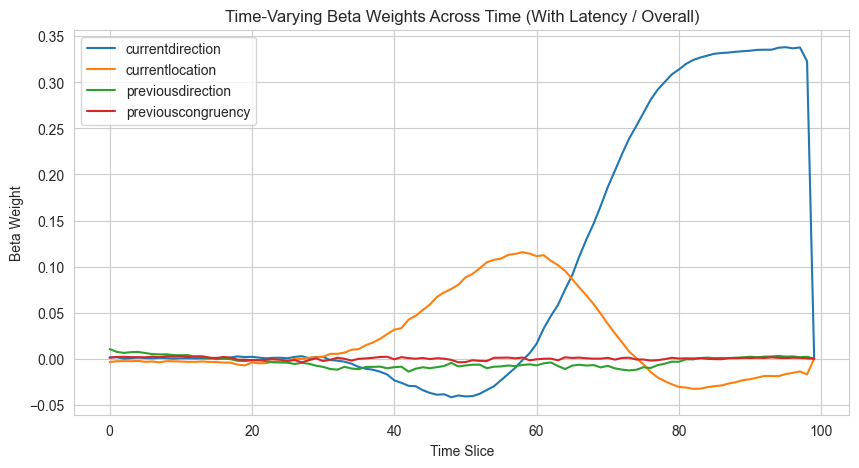

In [148]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(beta_weights_with_latency_overall.index, beta_weights_with_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
plt.xlabel("Time Slice")
plt.ylabel("Beta Weight")
plt.legend()
plt.title(f"Time-Varying Beta Weights Across Time (With Latency / Overall)")
plt.show()


#### Peaks bei Gruppe ohne Latenz

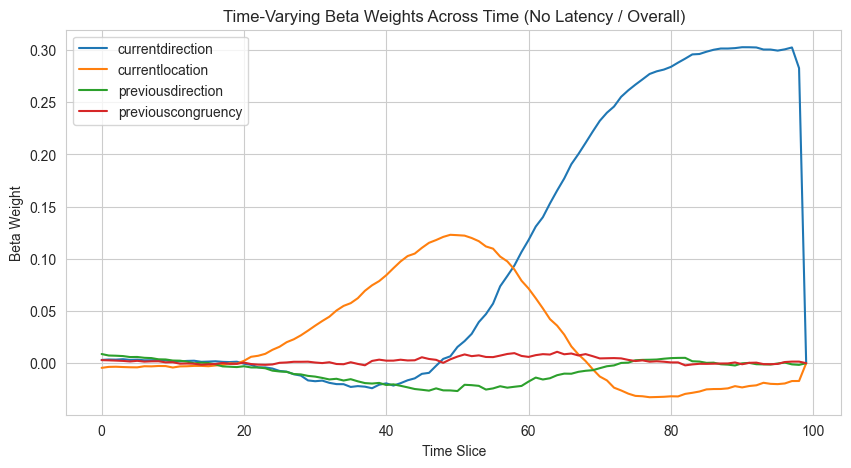

In [149]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(beta_weights_no_latency_overall.index, beta_weights_no_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
plt.xlabel("Time Slice")
plt.ylabel("Beta Weight")
plt.legend()
plt.title(f"Time-Varying Beta Weights Across Time (No Latency / Overall)")
plt.show()


#### T-Tests against zero und paired t-tests (zwischen Latenzkonditionen)

In [159]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_overall, beta_weights_per_participant_no_latency_overall, mean_reactiontimes_per_participant_with_latency_overall
, mean_reactiontimes_per_participant_no_latency_overall, "with_latency", "no_latency")

print('Comparison of beta weight peaks for trials with latency and trials without\n')
print(format_results(results, "with_latency", "no_latency"))

Comparison of beta weight peaks for trials with latency and trials without

Results for with_latency: 

The influence of currentdirection peaked at slice 96 (M(time) = 477 ms, M(beta) = 0.34, SE(beta) = 0.0011, t(13) = 303.54, p < .001). 
The influence of currentlocation peaked at slice 59 (M(time) = 293 ms, M(beta) = 0.12, SE(beta) = 0.0010, t(13) = 110.45, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 5 ms, M(beta) = 0.01, SE(beta) = 0.0008, t(13) = 12.81, p < .001). 
The influence of previouscongruency peaked at slice 11 (M(time) = 55 ms, M(beta) = 0.00, SE(beta) = 0.0001, t(13) = 23.14, p < .001). 

Results for no_latency: 

The influence of currentdirection peaked at slice 91 (M(time) = 400 ms, M(beta) = 0.30, SE(beta) = 0.0009, t(13) = 334.23, p < .001). 
The influence of currentlocation peaked at slice 50 (M(time) = 220 ms, M(beta) = 0.12, SE(beta) = 0.0011, t(13) = 113.08, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 

#### t-tests zwischen schnellen Bins (Latenz vs ohne Latenz)

In [160]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_fast, beta_weights_per_participant_no_latency_fast, mean_reactiontimes_per_participant_with_latency_fast, mean_reactiontimes_per_participant_no_latency_fast, "with_latency_fast", "no_latency_fast")

print('Comparison of beta weight peaks for fast trials \n')
print(format_results(results, "with_latency_fast", "no_latency_fast"))

Comparison of beta weight peaks for fast trials 

Results for with_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 415 ms, M(beta) = 0.34, SE(beta) = 0.0011, t(13) = 299.54, p < .001). 
The influence of currentlocation peaked at slice 64 (M(time) = 271 ms, M(beta) = 0.14, SE(beta) = 0.0013, t(13) = 106.54, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 4 ms, M(beta) = 0.01, SE(beta) = 0.0008, t(13) = 12.14, p < .001). 
The influence of previouscongruency peaked at slice 59 (M(time) = 250 ms, M(beta) = 0.01, SE(beta) = 0.0002, t(13) = 30.68, p < .001). 

Results for no_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 353 ms, M(beta) = 0.31, SE(beta) = 0.0012, t(13) = 266.95, p < .001). 
The influence of currentlocation peaked at slice 58 (M(time) = 209 ms, M(beta) = 0.14, SE(beta) = 0.0012, t(13) = 115.64, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 4 ms, M(beta) =

#### t-test zwischen langsamen Bins (latenz vs ohne Latenz)

In [161]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_slow, beta_weights_per_participant_no_latency_slow, mean_reactiontimes_per_participant_with_latency_slow, mean_reactiontimes_per_participant_no_latency_slow, "with_latency_slow", "no_latency_slow")

print('Comparison of beta weight peaks for slow trials \n')
print(format_results(results, "with_latency_slow", "no_latency_slow"))

Comparison of beta weight peaks for slow trials 

Results for with_latency_slow: 

The influence of currentdirection peaked at slice 96 (M(time) = 549 ms, M(beta) = 0.34, SE(beta) = 0.0012, t(13) = 277.98, p < .001). 
The influence of currentlocation peaked at slice 54 (M(time) = 309 ms, M(beta) = 0.13, SE(beta) = 0.0015, t(13) = 90.36, p < .001). 
The influence of previousdirection peaked at slice 1 (M(time) = 6 ms, M(beta) = 0.01, SE(beta) = 0.0008, t(13) = 12.39, p < .001). 
The influence of previouscongruency peaked at slice 38 (M(time) = 217 ms, M(beta) = 0.01, SE(beta) = 0.0004, t(13) = 14.22, p < .001). 

Results for no_latency_slow: 

The influence of currentdirection peaked at slice 95 (M(time) = 342 ms, M(beta) = 0.30, SE(beta) = 0.0012, t(13) = 259.61, p < .001). 
The influence of currentlocation peaked at slice 46 (M(time) = 166 ms, M(beta) = 0.13, SE(beta) = 0.0013, t(13) = 105.34, p < .001). 
The influence of previousdirection peaked at slice 83 (M(time) = 299 ms, M(beta)